# EE559 Project - NBA Dataset

**Shauryasikt Jena**

**5057859099**

## Libraries

In [36]:
## Import necessary libraries

import numpy as np
import pandas as pd
import scipy as sc

from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, ARDRegression
from sklearn.neighbors import KNeighborsRegressor

from tqdm import tqdm
from time import time
import warnings
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
warnings.filterwarnings('ignore')

In [37]:
# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Analyse Dataset

In [4]:
# Read the dataset with all stats for reviewing info
df_stats_all = pd.read_csv('NBA_player_datasets/NBA_player_stats_all.csv', index_col=[0])
df_stats_all.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,27,...,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,24,...,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,58,...,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,9,...,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,10,...,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97


In [5]:
df_stats_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12305 entries, 0 to 12304
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_name        12305 non-null  object 
 1   team_abbreviation  12305 non-null  object 
 2   age                12305 non-null  float64
 3   player_height      12305 non-null  float64
 4   player_weight      12305 non-null  float64
 5   college            12305 non-null  object 
 6   country            12305 non-null  object 
 7   draft_year         12305 non-null  object 
 8   draft_round        12305 non-null  object 
 9   draft_number       12305 non-null  object 
 10  gp                 12305 non-null  int64  
 11  pts                12305 non-null  float64
 12  reb                12305 non-null  float64
 13  ast                12305 non-null  float64
 14  net_rating         12305 non-null  float64
 15  oreb_pct           12305 non-null  float64
 16  dreb_pct           123

In [6]:
df_stats_all.isna().sum()

player_name          0
team_abbreviation    0
age                  0
player_height        0
player_weight        0
college              0
country              0
draft_year           0
draft_round          0
draft_number         0
gp                   0
pts                  0
reb                  0
ast                  0
net_rating           0
oreb_pct             0
dreb_pct             0
usg_pct              0
ts_pct               0
ast_pct              0
season               0
dtype: int64

In [7]:
df_aux = df_stats_all.copy(deep=True)

df_aux['draft_number'].replace('Undrafted', 0, inplace=True)
df_aux['draft_number'] = df_aux['draft_number'].astype('int64')
last_draft = max(df_aux['draft_number'])

In [8]:
df_stats_all.columns

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object')

## I - Regression: Demographic Attributes

### Preprocessing 

In [9]:
## Clean column data and create new columns to reflect that
def Df_Cleaner(df_):
    # Unchanged original df
    df = df_.copy(deep=True)

    ## Draft Number
    df['draft_number'].replace('Undrafted', 0, inplace=True) # Encode undrafted as 0
    draft_number_list = df['draft_number'].astype('int64') # convert all strings to int
    df['draft_number'] = draft_number_list

    # Bin draft numbers into stages
    df.loc[df['draft_number'].between(0, 0, 'both'), 'draft_stage'] = 'Undrafted'
    for i in range(1, last_draft, 5):
        title = str(i) + '-' + str(i+4)
        df.loc[df['draft_number'].between(i, i+4, 'both'), 'draft_stage'] = title
    
    ## Draft year and season
    # Take the ending year of the season
    year_list = []
    for i, val in enumerate(df['season']):
        year_list.append(int(val.split('-')[0]) + 1)
    df['year_list'] = year_list

    # Convert undrafted to 0 for draft_year
    df['draft_year'].replace('Undrafted', 0, inplace=True)
    draft_year_list = df['draft_year'].astype('int64') # Convert all years into int type
    df['draft_year'] = draft_year_list
    
    # Count experience
    df['Experience'] = df['year_list'] - df['draft_year']
    # Make undrafted values back to zero (for neutral math effect)
    exp_list = []
    for i, val in enumerate(df['Experience']):
        if val > 100:
            exp_list.append(0)
        else:
            exp_list.append(int(val))
    # Ensure experience is int type
    df['Experience'] = exp_list
 
    ## Drop draft number and draft year columns
    df.drop(['player_name', 'draft_year', 'draft_number', 'season', 'year_list'], axis=1, inplace=True)

    return df

## Preprocess all columns
def Df_RegOneHot(df_):
    # Unchanged original df
    df = df_.copy(deep=True)

    # Columns for one-hot encoding
    df = pd.get_dummies(data=df, columns=['team_abbreviation', 'college', 'country', \
                                          'draft_round', 'draft_stage'])
    # # MinMax Scaling
    # mm_scaler = MinMaxScaler()
    # df[mm_cols] = mm_scaler.fit_transform(df[mm_cols])

    # # Robust Scaling
    # rb_scaler = RobustScaler()
    # df[rb_cols] = rb_scaler.fit_transform(df[rb_cols])

    return df 

In [10]:
# Read into the training dataframe
df_all = pd.read_csv('NBA_player_datasets/NBA_player_stats_all.csv', index_col=[0])
df_all.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,27,...,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,24,...,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,58,...,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,9,...,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,10,...,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97


In [11]:
# Clean the training dataframe
df_all_cleaned = Df_Cleaner(df_all)
df_all_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12305 entries, 0 to 12304
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   team_abbreviation  12305 non-null  object 
 1   age                12305 non-null  float64
 2   player_height      12305 non-null  float64
 3   player_weight      12305 non-null  float64
 4   college            12305 non-null  object 
 5   country            12305 non-null  object 
 6   draft_round        12305 non-null  object 
 7   gp                 12305 non-null  int64  
 8   pts                12305 non-null  float64
 9   reb                12305 non-null  float64
 10  ast                12305 non-null  float64
 11  net_rating         12305 non-null  float64
 12  oreb_pct           12305 non-null  float64
 13  dreb_pct           12305 non-null  float64
 14  usg_pct            12305 non-null  float64
 15  ts_pct             12305 non-null  float64
 16  ast_pct            123

In [12]:
# Perform Preprocessing
df_all_preproc = Df_RegOneHot(df_all_cleaned)
df_all_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12305 entries, 0 to 12304
Columns: 513 entries, age to draft_stage_Undrafted
dtypes: float64(12), int64(2), uint8(499)
memory usage: 7.3 MB


### Features and Labels

In [13]:
# Separate X and y from train data
df_demo_X1 = df_all_preproc.drop(['pts', 'reb', 'ast'], axis=1)
df_demo_X = df_demo_X1.drop(['gp', 'net_rating', 'oreb_pct', 'dreb_pct',\
                             'usg_pct', 'ts_pct', 'ast_pct', 'Experience'], axis=1)
df_demo_y = df_all_preproc[['pts', 'reb', 'ast']].copy()

# Convert to numpy arrays for ML
np_demo_X = df_demo_X.to_numpy()
np_demo_y = df_demo_y.to_numpy()
np_demo_X.shape, np_demo_y.shape

((12305, 502), (12305, 3))

In [14]:
# For the non one-hot encoded features
marker = 3

In [15]:
np_demo_X_train, np_demo_X_test, np_demo_y_train, np_demo_y_test = train_test_split(\
                                                                    np_demo_X, np_demo_y, \
                                                                    test_size=0.2, random_state=42)

np_demo_pts_train, np_demo_pts_test = np_demo_y_train[:, 0], np_demo_y_test[:, 0]
np_demo_reb_train, np_demo_reb_test = np_demo_y_train[:, 1], np_demo_y_test[:, 1]
np_demo_ast_train, np_demo_ast_test = np_demo_y_train[:, 2], np_demo_y_test[:, 2]

In [16]:
def ScaleCols(X, marker, mns=None, rngs=None):
    if mns == None and rngs == None:
        mns = []
        rngs = []
        for i in range(marker):
            X[:, i] = (X[:, i] - np.mean(X[:, i])) / (np.max(X[:, i]) - np.min(X[:, i]))
            mns.append(np.mean(X[:, i]))
            rngs.append((np.max(X[:, i]) - np.min(X[:, i])))
        return X, mns, rngs
    else:
        for i in range(marker):
            X[:, i] = (X[:, i] - mns[i]) / rngs[i]
        return X, mns, rngs

np_demo_X1_train, mn_X, rng_X = ScaleCols(X=np_demo_X_train, marker=marker)
np_demo_X_test, _, _ = ScaleCols(X=np_demo_X_test, marker=marker)

### (i) Trivial System

In [17]:
## Trivial System

print("TRAINING")
trivial_pts = np.ones_like(np_demo_pts_train) * np.mean(np_demo_pts_train)
trivial_reb = np.ones_like(np_demo_reb_train) * np.mean(np_demo_reb_train)
trivial_ast = np.ones_like(np_demo_ast_train) * np.mean(np_demo_ast_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_train, trivial_pts, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_train, trivial_reb, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_train, trivial_ast, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_train, trivial_pts)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_train, trivial_reb)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_train, trivial_ast)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_train, trivial_pts)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_train, trivial_reb)}')
print(f'R2 for assists = {r2_score(np_demo_ast_train, trivial_ast)}')
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print("TESTING")
trivial_pts = np.ones_like(np_demo_pts_test) * np.mean(np_demo_pts_train)
trivial_reb = np.ones_like(np_demo_reb_test) * np.mean(np_demo_reb_train)
trivial_ast = np.ones_like(np_demo_ast_test) * np.mean(np_demo_ast_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_test, trivial_pts, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_test, trivial_reb, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_test, trivial_ast, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_test, trivial_pts)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_test, trivial_reb)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_test, trivial_ast)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_test, trivial_pts)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_test, trivial_reb)}')
print(f'R2 for assists = {r2_score(np_demo_ast_test, trivial_ast)}')

TRAINING
RMSE for points = 5.949127297635777
RMSE for rebounds = 2.479806163369718
RMSE for assists = 1.7850477476805116
-------------------------------------------------------------------------------------
MAE for points = 4.729136704471098
MAE for rebounds = 1.905678802649244
MAE for assists = 1.3086673665459099
-------------------------------------------------------------------------------------
R2 for points = 0.0
R2 for rebounds = 0.0
R2 for assists = 0.0
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 6.076248737450428
RMSE for rebounds = 2.4979706895843754
RMSE for assists = 1.8298874959213158
-------------------------------------------------------------------------------------
MAE for points = 4.827950728644382
MAE for rebounds = 1.8908611354604403
MAE for assists = 1.339785047389417
-----------------------------------------------

### (ii) Baseline Systems

#### (a) 1NN

In [18]:
## Baseline system - KNN with K = 1

# Points
knn_pts = KNeighborsRegressor(n_neighbors=1)
knn_pts.fit(np_demo_X1_train, np_demo_pts_train)
# Rebounds
knn_reb = KNeighborsRegressor(n_neighbors=1)
knn_reb.fit(np_demo_X1_train, np_demo_reb_train)
# Assists
knn_ast = KNeighborsRegressor(n_neighbors=1)
knn_ast.fit(np_demo_X1_train, np_demo_ast_train)

print("TRAINING")
pts_1nn = knn_pts.predict(np_demo_X1_train)
reb_1nn = knn_reb.predict(np_demo_X1_train)
ast_1nn = knn_ast.predict(np_demo_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_train, pts_1nn, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_train, reb_1nn, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_train, ast_1nn, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_train, pts_1nn)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_train, reb_1nn)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_train, ast_1nn)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_train, pts_1nn)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_train, reb_1nn)}')
print(f'R2 for assists = {r2_score(np_demo_ast_train, ast_1nn)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print("TESTING")
pts_1nn = knn_pts.predict(np_demo_X_test)
reb_1nn = knn_reb.predict(np_demo_X_test)
ast_1nn = knn_ast.predict(np_demo_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_test, pts_1nn, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_test, reb_1nn, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_test, ast_1nn, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_test, pts_1nn)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_test, reb_1nn)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_test, ast_1nn)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_test, pts_1nn)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_test, reb_1nn)}')
print(f'R2 for assists = {r2_score(np_demo_ast_test, ast_1nn)}')

TRAINING
RMSE for points = 0.0
RMSE for rebounds = 0.0
RMSE for assists = 0.0
-------------------------------------------------------------------------------------
MAE for points = 0.0
MAE for rebounds = 0.0
MAE for assists = 0.0
-------------------------------------------------------------------------------------
R2 for points = 1.0
R2 for rebounds = 1.0
R2 for assists = 1.0
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 3.6978633583881972
RMSE for rebounds = 1.61832632351901
RMSE for assists = 1.048378713858536
-------------------------------------------------------------------------------------
MAE for points = 2.7186915887850467
MAE for rebounds = 1.1268996342950022
MAE for assists = 0.6829744006501423
-------------------------------------------------------------------------------------
R2 for points = 0.629473497145196
R2 for reboun

#### (b) Simple Linear Regression

In [19]:
## Baseline system - Linear Regression with lambda = 0

# Points
lin_pts = LinearRegression()
lin_pts.fit(np_demo_X1_train, np_demo_pts_train)
# Rebounds
lin_reb = LinearRegression()
lin_reb.fit(np_demo_X1_train, np_demo_reb_train)
# Assists
lin_ast = LinearRegression()
lin_ast.fit(np_demo_X1_train, np_demo_ast_train)

print('TRAINING')
pts_lin = lin_pts.predict(np_demo_X1_train)
reb_lin = lin_reb.predict(np_demo_X1_train)
ast_lin = lin_ast.predict(np_demo_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_train, pts_lin, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_train, reb_lin, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_train, ast_lin, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_train, pts_lin)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_train, reb_lin)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_train, ast_lin)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_train, pts_lin)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_train, reb_lin)}')
print(f'R2 for assists = {r2_score(np_demo_ast_train, ast_lin)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
pts_lin = lin_pts.predict(np_demo_X_test)
reb_lin = lin_reb.predict(np_demo_X_test)
ast_lin = lin_ast.predict(np_demo_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_test, pts_lin, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_test, reb_lin, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_test, ast_lin, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_test, pts_lin)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_test, reb_lin)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_test, ast_lin)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_test, pts_lin)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_test, reb_lin)}')
print(f'R2 for assists = {r2_score(np_demo_ast_test, ast_lin)}')

TRAINING
RMSE for points = 4.818743039136804
RMSE for rebounds = 1.8687186293100968
RMSE for assists = 1.3173995505506713
-------------------------------------------------------------------------------------
MAE for points = 3.719449289035913
MAE for rebounds = 1.4029048084195481
MAE for assists = 0.945372257906942
-------------------------------------------------------------------------------------
R2 for points = 0.34391363496367566
R2 for rebounds = 0.43212550962748075
R2 for assists = 0.455327627483344
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 17685070148.935375
RMSE for rebounds = 17108581534.482468
RMSE for assists = 34179504332.05432
-------------------------------------------------------------------------------------
MAE for points = 1032233710.1778843
MAE for rebounds = 998585496.3350381
MAE for assists = 1994972943.627317


### (iii) Non-Probabilistic Models

#### (a) Multinomial Regression

In [20]:
## Multinomial Ridge

class MSE_Regressor():
    
    def __init__(self, degree = 1, lamda = 0, marker=1):
        self.degree = degree
        self.lamda = lamda
        self.reg_l2 = Ridge(alpha = self.lamda, fit_intercept=False) # Set fit_intercept False as directed
        self.regularized = None
        self.marker = marker

    def PolynomialTransforms(self, X, degree=1):
        poly_fts = PolynomialFeatures(degree)
        poly_X = poly_fts.fit_transform(X[:, :self.marker])     # apply transforms to certain columns
        X_fin = np.hstack((poly_X, X[:, self.marker:]))
        return X_fin

    def fit(self, X, y):
        X_new = self.PolynomialTransforms(X, degree=self.degree)     # apply polynomial feature transforms to X
        self.regularized = self.reg_l2.fit(X_new, y)

    def predict(self, X):
        X_new = self.PolynomialTransforms(X, degree=self.degree)     # apply polynomial feature transforms to X
        y_pred = self.regularized.predict(X_new)
        return y_pred

In [21]:
best_params_pts = {'degree': 1, 'lamda': 0}
best_params_reb = {'degree': 1, 'lamda': 0}
best_params_ast = {'degree': 1, 'lamda': 0}

# grids for search 
degrees = [4, 5, 6, 7]
lamdas = [0.1, 0.3, 1, 3, 10]

# to isolate best model
rmse_pts, r2_pts = 100, 0
rmse_reb, r2_reb = 100, 0
rmse_ast, r2_ast = 100, 0

for degree in degrees:
    for lamda in lamdas:
        clf = MSE_Regressor(degree=degree, lamda=lamda, marker=marker)
        # Use K-fold validation for 5 folds
        kfold = KFold(n_splits=5)
        for idx, (train_idx, val_idx) in enumerate(kfold.split(np_demo_X_train)):
            X_train, X_val = np_demo_X_train[train_idx], np_demo_X_train[val_idx]
            X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
            X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
            
            # Points
            y_train, y_val = np_demo_pts_train[train_idx], np_demo_pts_train[val_idx]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            # Decide on RMSE and R2
            rmse_1 = mean_squared_error(y_val, y_pred, squared=False)
            r2_1 = r2_score(y_val, y_pred)
            if (rmse_1 < rmse_pts):
                rmse_pts = rmse_1
                r2_pts = r2_1
                best_params_pts['degree'] = degree
                best_params_pts['lamda'] = lamda

            # Rebounds
            y_train, y_val = np_demo_reb_train[train_idx], np_demo_reb_train[val_idx]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            # Decide on RMSE and R2
            rmse_1 = mean_squared_error(y_val, y_pred, squared=False)
            r2_1 = r2_score(y_val, y_pred)
            if (rmse_1 < rmse_reb):
                rmse_reb = rmse_1
                r2_reb = r2_1
                best_params_reb['degree'] = degree
                best_params_reb['lamda'] = lamda

            # Assists
            y_train, y_val = np_demo_ast_train[train_idx], np_demo_ast_train[val_idx]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            # Decide on RMSE and R2
            rmse_1 = mean_squared_error(y_val, y_pred, squared=False)
            r2_1 = r2_score(y_val, y_pred)
            if (rmse_1 < rmse_ast):
                rmse_ast = rmse_1
                r2_ast = r2_1
                best_params_ast['degree'] = degree
                best_params_ast['lamda'] = lamda

In [22]:
print("Best Params for Points =", best_params_pts)
print("Best Params for Rebounds =", best_params_reb)
print("Best Params for Assists =", best_params_ast)

Best Params for Points = {'degree': 7, 'lamda': 0.1}
Best Params for Rebounds = {'degree': 4, 'lamda': 3}
Best Params for Assists = {'degree': 4, 'lamda': 0.1}


In [23]:
## Results

# Points
reg_pts = MSE_Regressor(degree=best_params_pts['degree'], lamda=best_params_pts['lamda'], marker=marker)
reg_pts.fit(np_demo_X1_train, np_demo_pts_train)
# Rebounds
reg_reb = MSE_Regressor(degree=best_params_reb['degree'], lamda=best_params_reb['lamda'], marker=marker)
reg_reb.fit(np_demo_X1_train, np_demo_reb_train)
# Assists
reg_ast = MSE_Regressor(degree=best_params_ast['degree'], lamda=best_params_ast['lamda'], marker=marker)
reg_ast.fit(np_demo_X1_train, np_demo_ast_train)

print('TRAINING')
pts_reg = reg_pts.predict(np_demo_X1_train)
reb_reg = reg_reb.predict(np_demo_X1_train)
ast_reg = reg_ast.predict(np_demo_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_train, pts_reg, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_train, reb_reg, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_train, ast_reg, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_train, pts_reg)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_train, reb_reg)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_train, ast_reg)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_train, pts_reg)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_train, reb_reg)}')
print(f'R2 for assists = {r2_score(np_demo_ast_train, ast_reg)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
pts_reg = reg_pts.predict(np_demo_X_test)
reb_reg = reg_reb.predict(np_demo_X_test)
ast_reg = reg_ast.predict(np_demo_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_test, pts_reg, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_test, reb_reg, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_test, ast_reg, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_test, pts_reg)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_test, reb_reg)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_test, ast_reg)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_test, pts_reg)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_test, reb_reg)}')
print(f'R2 for assists = {r2_score(np_demo_ast_test, ast_reg)}')

TRAINING
RMSE for points = 4.639115341320285
RMSE for rebounds = 1.8380839386957588
RMSE for assists = 1.2808611233914948
-------------------------------------------------------------------------------------
MAE for points = 3.5760113514507426
MAE for rebounds = 1.3810551908327393
MAE for assists = 0.9131131867424833
-------------------------------------------------------------------------------------
R2 for points = 0.39191566304784453
R2 for rebounds = 0.4505917074514024
R2 for assists = 0.48512190742206784
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 4.814374796067937
RMSE for rebounds = 1.903784089907755
RMSE for assists = 1.3462738683304596
-------------------------------------------------------------------------------------
MAE for points = 3.727775771171548
MAE for rebounds = 1.4165940242865407
MAE for assists = 0.95572469317928

#### (b) RBF Kernel Ridge

In [24]:
## RBF Network, designed as a scikit estimator

fold_gammas = []

class RBFNetwork():

    def __init__(self, factor, center_type, lamda, M=None, K=None):
        self.factor = factor            # power of 10 multiplied with gamma_d
        self.center_type = center_type  # defintion of basis function centers
        self.K = K                      # For KMeans
        self.M = M                      # No. of basis function centers
        self.lamda = lamda              # For Ridge Layer

    # find gamma_d from M
    def gamma_from_M(self, X):
        delta = np.max(X,axis = 0) - np.min(X,axis = 0)
        D = delta.shape[0]
        if self.center_type == 3:
            self.M = self.K
        alpha = np.power(np.prod(delta)/self.M, 1/float(D))
        sigma = 5*alpha
        if (sigma == 0):
            self.gamma_d = 1 # to handle division by 0
        else:
            self.gamma_d = 1/(2*(sigma**2))
        return self.gamma_d

    # get basis function centers
    def get_centers(self, X):
        if self.center_type == 1:   # -> Equals samples
            self.centers = np.copy(X)
        elif self.center_type == 2: # -> Random selections from samples
            self.centers = X[np.random.choice(len(X), size=self.M, replace=False)]
        elif self.center_type == 3: # -> KMeans cluster centers from sample data
            self.M = self.K
            kmeans = KMeans(n_clusters=self.K, init='random', random_state=42).fit(X)
            self.centers = kmeans.cluster_centers_
        else:
            print("ERROR: Invalid center_type")
        return self.centers

    # Reproducible params for rbf kernel calculations
    def get_model_params(self, X):
        self.gamma_d = self.gamma_from_M(X)
        self.gamma = self.factor * self.gamma_d
        self.centers = self.get_centers(X)

    # get modified featureset of X via rbf kernel
    def get_rbfs(self, X):
        return rbf_kernel(X, self.centers, self.gamma)

    # Fit to Training Data, return basis function centers
    def fit(self, X, y):
        self.get_model_params(X)
        rbfs = self.get_rbfs(X)
        rbfs = np.nan_to_num(rbfs)
        # print(np.count_nonzero(np.isnan(rbfs)))
        self.lin = Ridge(alpha = self.lamda, fit_intercept=False)
        self.lin.fit(rbfs, y)
        fold_gammas.append(self.gamma) # store gammas
        return self.centers
    
    # Predict function
    def predict(self, X):
        rbfs = self.get_rbfs(X)
        y_pred = self.lin.predict(rbfs)
        return y_pred
    
    # Like Scikit
    def get_params(self, deep=True):
        return {"factor": self.factor, "center_type": self.center_type, "M": self.M, "K": self.K}

    # Like Scikit
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [25]:
# Using basis function centers as data points

logs_10 = np.array([0.01, 0.1, 1])
# lamdas = [0.001, 0.01, 0.1]
lamdas = [0.001, 0.01]

best_params_pts = {'gamma': 0,'lamda': 100}
best_params_reb = {'gamma': 0,'lamda': 100}
best_params_ast = {'gamma': 0,'lamda': 100}

# to isolate best model
rmse_pts, r2_pts = 100, 0
rmse_reb, r2_reb = 100, 0
rmse_ast, r2_ast = 100, 0


for lamda in lamdas:
    for factor in logs_10:
        # Use K-fold validation for 5 folds
        kfold = KFold(n_splits=5) # 5-fold cross validation
        pts_rmse_list = []
        reb_rmse_list = []
        ast_rmse_list = []
        # Model Selection for gamma
        fold_gammas = []
        for idx, (train_idx, val_idx) in enumerate(kfold.split(np_demo_X_train)):
            X_train, X_val = np_demo_X_train[train_idx], np_demo_X_train[val_idx]
            X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
            X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)

            # Points
            y_train, y_val = np_demo_pts_train[train_idx], np_demo_pts_train[val_idx]
            reg_pts = RBFNetwork(factor=factor, center_type=1, lamda=lamda, M=len(X_train)) # Define model
            centers = reg_pts.fit(X_train, y_train)                            # Fit, and obtain basis fn centers
            y_pred = reg_pts.predict(X_val)
            pts_rmse_list.append(mean_squared_error(y_val, y_pred, squared=False)) 

            # Rebounds
            y_train, y_val = np_demo_reb_train[train_idx], np_demo_reb_train[val_idx]
            reg_reb = RBFNetwork(factor=factor, center_type=1, lamda=lamda, M=len(X_train)) # Define model
            centers = reg_reb.fit(X_train, y_train)                            # Fit, and obtain basis fn centers
            y_pred = reg_reb.predict(X_val)
            reb_rmse_list.append(mean_squared_error(y_val, y_pred, squared=False)) 

            # Assists
            y_train, y_val = np_demo_ast_train[train_idx], np_demo_ast_train[val_idx]
            reg_ast = RBFNetwork(factor=factor, center_type=1, lamda=lamda, M=len(X_train)) # Define model
            centers = reg_ast.fit(X_train, y_train)                            # Fit, and obtain basis fn centers
            y_pred = reg_ast.predict(X_val)
            ast_rmse_list.append(mean_squared_error(y_val, y_pred, squared=False)) 

        pts_gammas = np.array(fold_gammas[0::3])
        reb_gammas = np.array(fold_gammas[1::3])
        ast_gammas = np.array(fold_gammas[2::3])
        
        # update best lamda for points
        if (np.mean(pts_rmse_list)) < rmse_pts:
            rmse_pts = np.mean(pts_rmse_list)
            best_params_pts['lamda'] = lamda
            best_params_pts['gamma'] = np.mean(pts_gammas)
            best_rbf_pts = reg_pts

        # update best lamda for rebounds
        if (np.mean(reb_rmse_list)) < rmse_reb:
            rmse_reb = np.mean(reb_rmse_list)
            best_params_reb['lamda'] = lamda
            best_params_reb['gamma'] = np.mean(reb_gammas)
            best_rbf_reb = reg_reb

        # update best lamda for assists
        if (np.mean(ast_rmse_list)) < rmse_ast:
            rmse_ast = np.mean(ast_rmse_list)
            best_params_ast['lamda'] = lamda
            best_params_ast['gamma'] = np.mean(ast_gammas)
            best_rbf_ast = reg_ast

print("Best Params for Points =", best_params_pts)
print("Best Params for Rebounds =", best_params_reb)
print("Best Params for Assists =", best_params_ast)

Best Params for Points = {'gamma': 1.0, 'lamda': 0.001}
Best Params for Rebounds = {'gamma': 1.0, 'lamda': 0.001}
Best Params for Assists = {'gamma': 1.0, 'lamda': 0.001}


In [26]:
## Results

# Points
best_rbf_pts.fit(np_demo_X1_train, np_demo_pts_train)
# Rebounds
best_rbf_reb.fit(np_demo_X1_train, np_demo_reb_train)
# Assists
best_rbf_ast.fit(np_demo_X1_train, np_demo_ast_train)

print('TRAINING')
pts_rbf = best_rbf_pts.predict(np_demo_X1_train)
reb_rbf = best_rbf_reb.predict(np_demo_X1_train)
ast_rbf = best_rbf_ast.predict(np_demo_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_train, pts_rbf, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_train, reb_rbf, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_train, ast_rbf, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_train, pts_rbf)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_train, reb_rbf)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_train, ast_rbf)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_train, pts_rbf)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_train, reb_rbf)}')
print(f'R2 for assists = {r2_score(np_demo_ast_train, ast_rbf)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
pts_rbf = best_rbf_pts.predict(np_demo_X_test)
reb_rbf = best_rbf_reb.predict(np_demo_X_test)
ast_rbf = best_rbf_ast.predict(np_demo_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_test, pts_rbf, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_test, reb_rbf, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_test, ast_rbf, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_test, pts_rbf)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_test, reb_rbf)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_test, ast_rbf)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_test, pts_rbf)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_test, reb_rbf)}')
print(f'R2 for assists = {r2_score(np_demo_ast_test, ast_rbf)}')

TRAINING
RMSE for points = 1.5912232355579716
RMSE for rebounds = 0.661458803092046
RMSE for assists = 0.4126177792892179
-------------------------------------------------------------------------------------
MAE for points = 0.9756102692310451
MAE for rebounds = 0.3861103022230077
MAE for assists = 0.2307613783903137
-------------------------------------------------------------------------------------
R2 for points = 0.9284588857657619
R2 for rebounds = 0.9288507819840908
R2 for assists = 0.9465686435212728
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 3.4637329837302704
RMSE for rebounds = 1.4717555265861253
RMSE for assists = 0.9570134740271762
-------------------------------------------------------------------------------------
MAE for points = 2.5970693310581017
MAE for rebounds = 1.0554185169659767
MAE for assists = 0.6555948608416

### (iv) Support Vector Machine

In [27]:
## Support Vector Regression

# best_params_pts = {'kernel': 'linear', 'gamma': 10, 'C': 0.1}
# best_params_reb = {'kernel': 'linear', 'gamma': 10, 'C': 0.1}
# best_params_ast = {'kernel': 'linear', 'gamma': 10, 'C': 0.1}
best_params_pts = {'kernel': 'rbf', 'gamma': 1, 'C': 30}
best_params_reb = {'kernel': 'rbf', 'gamma': 0.3, 'C': 30}
best_params_ast = {'kernel': 'rbf', 'gamma': 1, 'C': 30}

# # grids for search 
# kernels = ['rbf', 'sigmoid']
# gammas = [0.1, 0.3, 1]
# Cs = [1, 10, 30]

# # to isolate best model
# rmse_pts, r2_pts = 100, 0
# rmse_reb, r2_reb = 100, 0
# rmse_ast, r2_ast = 100, 0

# for kernel in kernels:
#     for gamma in gammas:
#         for C in Cs:
#             X_train, X_val, y_train, y_val = train_test_split(np_demo_X_train, np_demo_y_train, \
#                                                                 test_size=0.2, random_state=42)
#             X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
#             X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)                                                    
#             clf = SVR(kernel=kernel, gamma=gamma, C=C)

#             # Points
#             pts_train, pts_val = y_train[:, 0], y_val[:, 0]
#             clf.fit(X_train, pts_train)
#             pts_pred = clf.predict(X_val)
#             # Decide on RMSE and R2
#             rmse_1 = mean_squared_error(pts_val, pts_pred, squared=False)
#             r2_1 = r2_score(pts_val, pts_pred)
#             if (rmse_1 < rmse_pts):
#                 rmse_pts = rmse_1
#                 r2_pts = r2_1
#                 best_params_pts['kernel'] = kernel
#                 best_params_pts['gamma'] = gamma
#                 best_params_pts['C'] = C

#             # Rebounds
#             reb_train, reb_val = y_train[:, 1], y_val[:, 1]
#             clf.fit(X_train, reb_train)
#             reb_pred = clf.predict(X_val)
#             # Decide on RMSE and R2
#             rmse_1 = mean_squared_error(reb_val, reb_pred, squared=False)
#             r2_1 = r2_score(reb_val, reb_pred)
#             if (rmse_1 < rmse_reb):
#                 rmse_reb = rmse_1
#                 r2_reb = r2_1
#                 best_params_reb['kernel'] = kernel
#                 best_params_reb['gamma'] = gamma
#                 best_params_reb['C'] = C

#             # Assists
#             ast_train, ast_val = y_train[:, 2], y_val[:, 2]
#             clf.fit(X_train, ast_train)
#             ast_pred = clf.predict(X_val)
#             # Decide on RMSE and R2
#             rmse_1 = mean_squared_error(ast_val, ast_pred, squared=False)
#             r2_1 = r2_score(ast_val, ast_pred)
#             if (rmse_1 < rmse_ast):
#                 rmse_ast = rmse_1
#                 r2_ast = r2_1
#                 best_params_ast['kernel'] = kernel
#                 best_params_ast['gamma'] = gamma
#                 best_params_ast['C'] = C

print("Best Params for Points =", best_params_pts)
print("Best Params for Rebounds =", best_params_reb)
print("Best Params for Assists =", best_params_ast)

Best Params for Points = {'kernel': 'rbf', 'gamma': 1, 'C': 30}
Best Params for Rebounds = {'kernel': 'rbf', 'gamma': 0.3, 'C': 30}
Best Params for Assists = {'kernel': 'rbf', 'gamma': 1, 'C': 30}


In [28]:
## Results

# Points
svr_pts = SVR(kernel=best_params_pts['kernel'], gamma=best_params_pts['gamma'], C=best_params_pts['C'])
svr_pts.fit(np_demo_X1_train, np_demo_pts_train)
# Rebounds
svr_reb = SVR(kernel=best_params_reb['kernel'], gamma=best_params_reb['gamma'], C=best_params_reb['C'])
svr_reb.fit(np_demo_X1_train, np_demo_reb_train)
# Assists
svr_ast = SVR(kernel=best_params_ast['kernel'], gamma=best_params_ast['gamma'], C=best_params_ast['C'])
svr_ast.fit(np_demo_X1_train, np_demo_ast_train)

print('TRAINING')
pts_svr = svr_pts.predict(np_demo_X1_train)
reb_svr = svr_reb.predict(np_demo_X1_train)
ast_svr = svr_ast.predict(np_demo_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_train, pts_svr, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_train, reb_svr, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_train, ast_svr, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_train, pts_svr)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_train, reb_svr)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_train, ast_svr)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_train, pts_svr)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_train, reb_svr)}')
print(f'R2 for assists = {r2_score(np_demo_ast_train, ast_svr)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
pts_svr = svr_pts.predict(np_demo_X_test)
reb_svr = svr_reb.predict(np_demo_X_test)
ast_svr = svr_ast.predict(np_demo_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_test, pts_svr, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_test, reb_svr, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_test, ast_svr, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_test, pts_svr)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_test, reb_svr)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_test, ast_svr)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_test, pts_svr)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_test, reb_svr)}')
print(f'R2 for assists = {r2_score(np_demo_ast_test, ast_svr)}')

TRAINING
RMSE for points = 2.0438512315420727
RMSE for rebounds = 0.8644763779095103
RMSE for assists = 0.44832605729273073
-------------------------------------------------------------------------------------
MAE for points = 1.0403179289736606
MAE for rebounds = 0.454259384093789
MAE for assists = 0.23265362491294245
-------------------------------------------------------------------------------------
R2 for points = 0.8819701002483764
R2 for rebounds = 0.8784735557803381
R2 for assists = 0.9369204933674266
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 3.567430706727569
RMSE for rebounds = 1.490934002426446
RMSE for assists = 0.9652806084747723
-------------------------------------------------------------------------------------
MAE for points = 2.684995658833153
MAE for rebounds = 1.0833235599772604
MAE for assists = 0.67472684773649

### (v) Probabilistic Models

#### (a) KNN

In [29]:
## Probabilistic Regression - KNN

# best_params_pts = {'K': 1}
# best_params_reb = {'K': 1}
# best_params_ast = {'K': 1}
best_params_pts = {'K': 7}
best_params_reb = {'K': 8}
best_params_ast = {'K': 9}

# # grids for search 
# Ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# # to isolate best model
# rmse_pts, r2_pts = 100, 0
# rmse_reb, r2_reb = 100, 0
# rmse_ast, r2_ast = 100, 0

# for K in Ks:
#     X_train, X_val, y_train, y_val = train_test_split(np_demo_X_train, np_demo_y_train, \
#                                                         test_size=0.2, random_state=42)
#     X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
#     X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
#     clf = KNeighborsRegressor(n_neighbors=K, weights='distance')

#     # Points
#     pts_train, pts_val = y_train[:, 0], y_val[:, 0]
#     clf.fit(X_train, pts_train)
#     pts_pred = clf.predict(X_val)
#     # Decide on RMSE and R2
#     rmse_1 = mean_squared_error(pts_val, pts_pred, squared=False)
#     r2_1 = r2_score(pts_val, pts_pred)
#     if (rmse_1 < rmse_pts):
#         rmse_pts = rmse_1
#         r2_pts = r2_1
#         best_params_pts['K'] = K
        
#     # Rebounds
#     reb_train, reb_val = y_train[:, 1], y_val[:, 1]
#     clf.fit(X_train, reb_train)
#     reb_pred = clf.predict(X_val)
#     # Decide on RMSE and R2
#     rmse_1 = mean_squared_error(reb_val, reb_pred, squared=False)
#     r2_1 = r2_score(reb_val, reb_pred)
#     if (rmse_1 < rmse_reb):
#         rmse_reb = rmse_1
#         r2_reb = r2_1
#         best_params_reb['K'] = K

#     # Assists
#     ast_train, ast_val = y_train[:, 2], y_val[:, 2]
#     clf.fit(X_train, ast_train)
#     ast_pred = clf.predict(X_val)
#     # Decide on RMSE and R2
#     rmse_1 = mean_squared_error(ast_val, ast_pred, squared=False)
#     r2_1 = r2_score(ast_val, ast_pred)
#     if (rmse_1 < rmse_ast):
#         rmse_ast = rmse_1
#         r2_ast = r2_1
#         best_params_ast['K'] = K

print("Best Params for Points =", best_params_pts)
print("Best Params for Rebounds =", best_params_reb)
print("Best Params for Assists =", best_params_ast)

Best Params for Points = {'K': 7}
Best Params for Rebounds = {'K': 8}
Best Params for Assists = {'K': 9}


In [30]:
## Results

# Points
knn_pts = KNeighborsRegressor(n_neighbors=best_params_pts['K'], weights='distance')
knn_pts.fit(np_demo_X1_train, np_demo_pts_train)
# Rebounds
knn_reb = KNeighborsRegressor(n_neighbors=best_params_reb['K'], weights='distance')
knn_reb.fit(np_demo_X1_train, np_demo_reb_train)
# Assists
knn_ast = KNeighborsRegressor(n_neighbors=best_params_ast['K'], weights='distance')
knn_ast.fit(np_demo_X1_train, np_demo_ast_train)

print("TRAINING")
pts_1nn = knn_pts.predict(np_demo_X1_train)
reb_1nn = knn_reb.predict(np_demo_X1_train)
ast_1nn = knn_ast.predict(np_demo_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_train, pts_1nn, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_train, reb_1nn, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_train, ast_1nn, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_train, pts_1nn)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_train, reb_1nn)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_train, ast_1nn)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_train, pts_1nn)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_train, reb_1nn)}')
print(f'R2 for assists = {r2_score(np_demo_ast_train, ast_1nn)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print("TESTING")
pts_1nn = knn_pts.predict(np_demo_X_test)
reb_1nn = knn_reb.predict(np_demo_X_test)
ast_1nn = knn_ast.predict(np_demo_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_test, pts_1nn, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_test, reb_1nn, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_test, ast_1nn, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_test, pts_1nn)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_test, reb_1nn)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_test, ast_1nn)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_test, pts_1nn)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_test, reb_1nn)}')
print(f'R2 for assists = {r2_score(np_demo_ast_test, ast_1nn)}')

TRAINING
RMSE for points = 0.0
RMSE for rebounds = 0.0
RMSE for assists = 0.0
-------------------------------------------------------------------------------------
MAE for points = 0.0
MAE for rebounds = 0.0
MAE for assists = 0.0
-------------------------------------------------------------------------------------
R2 for points = 1.0
R2 for rebounds = 1.0
R2 for assists = 1.0
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 3.522924706635211
RMSE for rebounds = 1.4724070874789417
RMSE for assists = 0.9398135383930867
-------------------------------------------------------------------------------------
MAE for points = 2.686404396387805
MAE for rebounds = 1.0809652571764812
MAE for assists = 0.6686366677539886
-------------------------------------------------------------------------------------
R2 for points = 0.6637020022618967
R2 for rebo

#### (b) Bayesian with Gaussian Prior

In [31]:
## Probabilistic Regression - Bayesian with Gaussian Prior

# best_params_pts = {'a1': 1, 'lam1': 1, 'a2': 1, 'lam2': 1}
# best_params_reb = {'a1': 1, 'lam1': 1, 'a2': 1, 'lam2': 1}
# best_params_ast = {'a1': 1, 'lam1': 1, 'a2': 1, 'lam2': 1}
best_params_pts = {'a1': 1e-2, 'lam1': 1e-6, 'a2': 1e-6, 'lam2': 1e-2}
best_params_reb = {'a1': 1e-2, 'lam1': 1e-6, 'a2': 1e-6, 'lam2': 1e-2}
best_params_ast = {'a1': 1e-2, 'lam1': 1e-6, 'a2': 1e-6, 'lam2': 1e-2}

# # grids for search 
# alphas_1 = [1e-6, 1e-4, 1e-2]
# alphas_2 = [1e-6, 1e-4, 1e-2]
# lamdas_1 = [1e-6, 1e-4, 1e-2]
# lamdas_2 = [1e-6, 1e-4, 1e-2]

# # to isolate best model
# rmse_pts, r2_pts = 100, 0
# rmse_reb, r2_reb = 100, 0
# rmse_ast, r2_ast = 100, 0

# for a1 in alphas_1:
#     for a2 in alphas_2:
#         for lam1 in lamdas_1:
#             for lam2 in lamdas_2:
#                 X_train, X_val, y_train, y_val = train_test_split(np_demo_X_train, np_demo_y_train, \
#                                                                   test_size=0.2, random_state=42)
#                 X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
#                 X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
#                 clf = ARDRegression(alpha_1=a1, alpha_2=a2, lambda_1=lam1, lambda_2=lam2)

#                 # Points
#                 pts_train, pts_val = y_train[:, 0], y_val[:, 0]
#                 clf.fit(X_train, pts_train)
#                 pts_pred = clf.predict(X_val)
#                 # Decide on RMSE and R2
#                 rmse_1 = mean_squared_error(pts_val, pts_pred, squared=False)
#                 r2_1 = r2_score(pts_val, pts_pred)
#                 if (rmse_1 < rmse_pts):
#                     rmse_pts = rmse_1
#                     r2_pts = r2_1
#                     best_params_pts['a1'] = a1
#                     best_params_pts['a2'] = a2
#                     best_params_pts['lam1'] = lam1
#                     best_params_pts['lam2'] = lam2

#                 # Rebounds
#                 reb_train, reb_val = y_train[:, 1], y_val[:, 1]
#                 clf.fit(X_train, reb_train)
#                 reb_pred = clf.predict(X_val)
#                 # Decide on RMSE and R2
#                 rmse_1 = mean_squared_error(reb_val, reb_pred, squared=False)
#                 r2_1 = r2_score(reb_val, reb_pred)
#                 if (rmse_1 < rmse_reb):
#                     rmse_reb = rmse_1
#                     r2_reb = r2_1
#                     best_params_reb['a1'] = a1
#                     best_params_reb['a2'] = a2
#                     best_params_reb['lam1'] = lam1
#                     best_params_reb['lam2'] = lam2

#                 # Assists
#                 ast_train, ast_val = y_train[:, 2], y_val[:, 2]
#                 clf.fit(X_train, ast_train)
#                 ast_pred = clf.predict(X_val)
#                 # Decide on RMSE and R2
#                 rmse_1 = mean_squared_error(ast_val, ast_pred, squared=False)
#                 r2_1 = r2_score(ast_val, ast_pred)
#                 if (rmse_1 < rmse_ast):
#                     rmse_ast = rmse_1
#                     r2_ast = r2_1
#                     best_params_ast['a1'] = a1
#                     best_params_ast['a2'] = a2
#                     best_params_ast['lam1'] = lam1
#                     best_params_ast['lam2'] = lam2

print("Best Params for Points =", best_params_pts)
print("Best Params for Rebounds =", best_params_reb)
print("Best Params for Assists =", best_params_ast)

Best Params for Points = {'a1': 0.01, 'lam1': 1e-06, 'a2': 1e-06, 'lam2': 0.01}
Best Params for Rebounds = {'a1': 0.01, 'lam1': 1e-06, 'a2': 1e-06, 'lam2': 0.01}
Best Params for Assists = {'a1': 0.01, 'lam1': 1e-06, 'a2': 1e-06, 'lam2': 0.01}


In [32]:
## Results

# Points
clf_pts = ARDRegression(alpha_1=best_params_pts['a1'], alpha_2=best_params_pts['a2'], \
                        lambda_1=best_params_pts['lam1'], lambda_2=best_params_pts['lam2'])
clf_pts.fit(np_demo_X1_train, np_demo_pts_train)
# Rebounds
clf_reb = ARDRegression(alpha_1=best_params_reb['a1'], alpha_2=best_params_reb['a2'], \
                        lambda_1=best_params_reb['lam1'], lambda_2=best_params_reb['lam2'])
clf_reb.fit(np_demo_X1_train, np_demo_reb_train)
# Assists
clf_ast = ARDRegression(alpha_1=best_params_ast['a1'], alpha_2=best_params_ast['a2'], \
                        lambda_1=best_params_ast['lam1'], lambda_2=best_params_ast['lam2'])
clf_ast.fit(np_demo_X1_train, np_demo_ast_train)

print('TRAINING')
pts_bay = clf_pts.predict(np_demo_X1_train)
reb_bay = clf_reb.predict(np_demo_X1_train)
ast_bay = clf_ast.predict(np_demo_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_train, pts_bay, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_train, reb_bay, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_train, ast_bay, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_train, pts_bay)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_train, reb_bay)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_train, ast_bay)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_train, pts_bay)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_train, reb_bay)}')
print(f'R2 for assists = {r2_score(np_demo_ast_train, ast_bay)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
pts_bay = clf_pts.predict(np_demo_X_test)
reb_bay = clf_reb.predict(np_demo_X_test)
ast_bay = clf_ast.predict(np_demo_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_demo_pts_test, pts_bay, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_demo_reb_test, reb_bay, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_demo_ast_test, ast_bay, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_demo_pts_test, pts_bay)}')
print(f'MAE for rebounds = {mean_absolute_error(np_demo_reb_test, reb_bay)}')
print(f'MAE for assists = {mean_absolute_error(np_demo_ast_test, ast_bay)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_demo_pts_test, pts_bay)}')
print(f'R2 for rebounds = {r2_score(np_demo_reb_test, reb_bay)}')
print(f'R2 for assists = {r2_score(np_demo_ast_test, ast_bay)}')

TRAINING
RMSE for points = 4.851802336134441
RMSE for rebounds = 1.8787629540231
RMSE for assists = 1.3237672125752828
-------------------------------------------------------------------------------------
MAE for points = 3.77362825891914
MAE for rebounds = 1.419185206349368
MAE for assists = 0.9542231336917776
-------------------------------------------------------------------------------------
R2 for points = 0.3348805091886561
R2 for rebounds = 0.4260044757772161
R2 for assists = 0.45004954524231855
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 4.979210156558267
RMSE for rebounds = 1.9420760857904271
RMSE for assists = 1.3678444230641895
-------------------------------------------------------------------------------------
MAE for points = 3.9059530709003476
MAE for rebounds = 1.4570321539340176
MAE for assists = 0.9878175689439805
--

### (vi) Neural Network

In [33]:
## Neural Network / MLP

n_fts = np_demo_X_train.shape[1]
n_hid = 2 * n_fts

# Define the model
class MLP(nn.Module):
    def __init__(self, n_fts, n_hid): # Define layers in the constructor
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_fts, n_hid, bias=True)     # set bias = True to include it
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hid, n_fts, bias=True)    # set bias = True to include it
        self.fc3 = nn.Linear(n_fts, 1, bias=True)
        
    def forward(self, x): # Define forward pass in the forward method
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP(n_fts, n_hid)

# Dataloader helper
class MLPDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Hyperparams for model
lr = 1e-2
reg_val = 1e-4
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

# Define function to call for each training epoch (one complete pass over the training set)
# (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
def train(model, trainloader, criterion, optimizer, device, disable=True): #disable controls tqdm visibility
    model.train() # set model to training mode
    running_loss = 0
    np_pred = np.array([[0]])
    with tqdm(total=len(trainloader), desc=f"Train", unit="batch", disable=disable) as pbar:
        for n_batch, (samples, labels) in enumerate(trainloader): # Iterate over batches
            samples, labels = samples.to(device), labels.to(device) # Move batch to device
            samples = samples.to(torch.float32)
            labels = labels.to(torch.float32)
            optimizer.zero_grad()
            output = model(samples) # Forward pass
            labels = labels.view(output.shape[0], 1)
            np_op = output.detach().numpy()
            np_pred = np.vstack((np_pred, np_op))
            loss = criterion(output, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            running_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            pbar.update() # Update progress bar
    return np.sqrt(running_loss / len(trainloader)), np_pred[1:] # return RMSE loss

# Define function to call for each validation epoch (one complete pass over the validation set)
# (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
def validate(model, valloader, criterion, device, disable=True): #disable controls tqdm visibility
    model.eval() # set model to evaluation mode (e.g. turn off dropout, batchnorm, etc.)
    running_loss = 0
    np_pred = np.array([[0]])
    with torch.no_grad(): # no need to compute gradients for validation
        with tqdm(total=len(valloader), desc=f"Eval", unit="batch", disable=disable) as pbar:
            for n_batch, (samples, labels) in enumerate(valloader): # Iterate over batches
                samples, labels = samples.to(device), labels.to(device) # Move batch to device
                samples = samples.to(torch.float32)
                labels = labels.to(torch.float32)
                output = model(samples) # Forward pass
                np_op = output.detach().numpy()
                np_pred = np.vstack((np_pred, np_op))
                labels = labels.view(output.shape[0], 1)
                # print(output.shape[0])
                loss = criterion(output, labels) # Compute loss
                running_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})
                pbar.update() # Update progress bar
    return np.sqrt(running_loss / len(valloader)), np_pred[1:]  # return RMSE loss

## Set device for training
# (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)

device = torch.device("cpu")
print(f'Using device: {device}')
model.to(device) # Move model to device

Using device: cpu


MLP(
  (fc1): Linear(in_features=502, out_features=1004, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1004, out_features=502, bias=True)
  (fc3): Linear(in_features=502, out_features=1, bias=True)
)

#### (a) For Points

POINTS
-----------------------------------------------------------------------
Batch size of 128 converges the fastest
Best Model Training Hyperparameters:
Learning Rate = 0.01
Lambda = 0.001


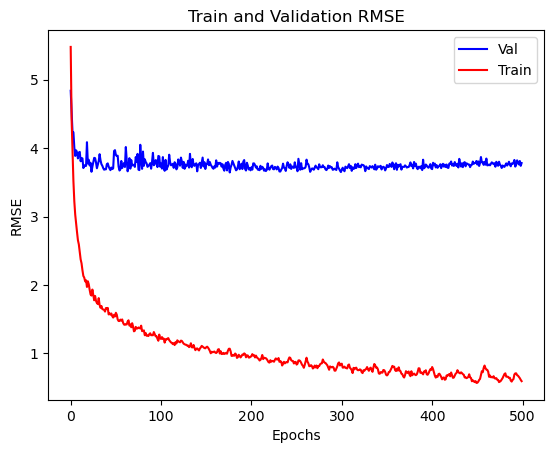

-----------------------------------------------------------------------
TRAINING
RMSE = 0.5687924946047499
MAE 0.3555162412159027
R2 0.9908563139853834
-----------------------------------------------------------------------
TESTING
RMSE = 3.6521101581107134
MAE 2.8002542686481777
R2 0.6385857300158184


In [34]:
# Points

print("POINTS")
print("-----------------------------------------------------------------------")


# val split
X_train, X_val, y_train, y_val = train_test_split(np_demo_X_train, np_demo_pts_train, \
                                                        test_size=0.2, random_state=42)
X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)

# Dataloader format
trainset = MLPDataset(X_train, y_train)
valset = MLPDataset(X_val, y_val)
testset = MLPDataset(np_demo_X_test, np_demo_pts_test)

# Run training and validation loop
# Save the quickest model to converge

n_epochs = 100

## Vary batchsizes for smallest run-time
# Sample batchsizes for training  
batchsizes_dict = {16: None, 32: None, 64: None, 128: None, 256: None} # to store runtimes
rts = [] # for runtimes

for B in batchsizes_dict:

    # print(f"Batch size = {B}")

    seeder = 33

    # refresh model for a fair iteration
    model = MLP(n_fts, n_hid)
    model.to(device)
    # for refreshed model
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

    best_rmse = 1000
    train_loss_history = []
    val_loss_history = []

    # time marker
    start = time()
    # Iterate over epochs
    # (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
    for epoch in range(n_epochs):
        # print(f"Epoch {epoch+1} of {n_epochs}")
        seeder += 1
        # Shuffle the data at the start of each epoch (only useful for training set)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=B, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+seeder))
        valloader = torch.utils.data.DataLoader(valset, batch_size=B, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+seeder))
        
        train_loss, train_pred = train(model, trainloader, criterion, optimizer, device, disable=True) # Train
        val_loss, val_pred = validate(model, valloader, criterion, device, disable=True) # Validate
        # mark the end of this epoch's training
        runtime = time() - start
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        Converged = False
        if val_loss < best_rmse: # Save best model
            # print("Updating best model")
            best_loss = val_loss
            # torch.save(model.state_dict(), "best_model_pts.pt") # saving model parameters ("state_dict") saves memory
        if val_loss <= 4 and train_loss <= 4: # convergence
            runtime_model = runtime
            Converged = True
            # print("Attained Stopping Condition")
            break
    if Converged:
        rts.append(runtime_model)
    else:
        rts.append(runtime)
    
    # print("-----------------------------------------------------------------------")

# Complete the dictionary
for key, val in zip(batchsizes_dict, rts):
    batchsizes_dict[key] = round(val, 3)

B_opt = min(batchsizes_dict, key=batchsizes_dict.get)
print(f"Batch size of {B_opt} converges the fastest")

# Run training and validation loop
# Save the best model 
n_epochs = 100
epochs = torch.arange(n_epochs)
best_loss = 1000

## Define grid for hyperparameter optimization
lrs = [1e-3, 1e-2, 1e-1] 
reg_vals = [1e-4, 1e-3, 1e-2]

lr_opt = 0
reg_val_opt = 0

for lr in lrs:
    for reg_val in reg_vals:
        # print(f"Learning rate = {lr} and Lambda = {reg_val}")

        model = MLP(n_fts=n_fts, n_hid=n_hid)
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

        # (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
        for epoch in range(n_epochs): # Iterate over epochs
            # if (epoch+1)%10 == 0:
                # print(f"Epoch {epoch+1} of {n_epochs}")
            # Shuffle the data at the start of each epoch (only useful for training set)
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=B_opt, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+epoch))
            valloader = torch.utils.data.DataLoader(valset, batch_size=B_opt, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+epoch))
            
            train_loss, train_pred = train(model, trainloader, criterion, optimizer, device) # Train
            val_loss, val_pred = validate(model, valloader, criterion, device) # Validate
            
        if val_loss < best_loss: # Save best model
            best_loss = val_loss
            lr_opt = lr
            reg_val_opt = reg_val
            # torch.save(model.state_dict(), "best_model_pts.pt") # saving model parameters ("state_dict") saves memory

        # print("-------------------------------------------------------------------------------------")

## Report Best Hyperparameters from Grid Search
print("Best Model Training Hyperparameters:")
print(f"Learning Rate = {lr_opt}\nLambda = {reg_val_opt}")

# Run training and validation loop
# Save the best model
n_epochs = 500

seeder = 33

model = MLP(n_fts=n_fts, n_hid=n_hid)
model.to(device)
# for refreshed model
optimizer = optim.AdamW(model.parameters(), lr=lr_opt, weight_decay=reg_val_opt)

best_loss = 1000
val_list = []
train_list = []
# Iterate over epochs
# (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
for epoch in range(n_epochs):
    # if (epoch+1)%100 == 0:
        # print(f"Epoch {epoch+1} of {n_epochs}")

    seeder += 1
    # Shuffle the data at the start of each epoch (only useful for training set)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=B_opt, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+seeder))
    valloader = torch.utils.data.DataLoader(valset, batch_size=B_opt, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+seeder))
    
    train_loss, train_pred = train(model, trainloader, criterion, optimizer, device, disable=True) # Train
    val_loss, val_pred = validate(model, valloader, criterion, device, disable=True) # Validate
    train_list.append(train_loss)
    val_list.append(val_loss)
    
    if val_loss < best_loss: # best val accuracy over epochs
        best_loss = val_loss
        # print("Updating best model")
        loss_train = train_loss
        y_val_pred = val_pred
        torch.save(model.state_dict(), "NN_Demo_best_model_pts.pt")

plt.figure()
plt.plot(range(n_epochs), val_list, color='blue')
plt.plot(range(n_epochs), train_list, color='red')
plt.title("Train and Validation RMSE")
plt.legend(["Val", "Train"])
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

# Metrics
B_opt = 256
mlp = MLP(n_fts=n_fts, n_hid=n_hid)
mlp.load_state_dict(torch.load("NN_Demo_best_model_pts.pt"))

trainloader = DataLoader(trainset, batch_size=B_opt, shuffle=False)
err, y_train_pred = validate(model, trainloader, criterion, device)
y_train_pred = y_train_pred.reshape(len(y_train_pred),)

print("-----------------------------------------------------------------------")
print("TRAINING")
print("RMSE =", mean_squared_error(y_train, y_train_pred, squared=False))
print("MAE", mean_absolute_error(y_train, y_train_pred))
print("R2", r2_score(y_train, y_train_pred))
print("-----------------------------------------------------------------------")

testloader = DataLoader(testset, batch_size=B_opt, shuffle=False)
err, y_test_pred = validate(model, testloader, criterion, device)
y_test_pred = y_test_pred.reshape(len(y_test_pred),)
y_test = np_demo_pts_test

print("TESTING")
print("RMSE =", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE", mean_absolute_error(y_test, y_test_pred))
print("R2", r2_score(y_test, y_test_pred))

#### (b) For Rebounds

REBOUNDS
-----------------------------------------------------------------------
Batch size of 128 converges the fastest
Best Model Training Hyperparameters:
Learning Rate = 0.001
Lambda = 0.001


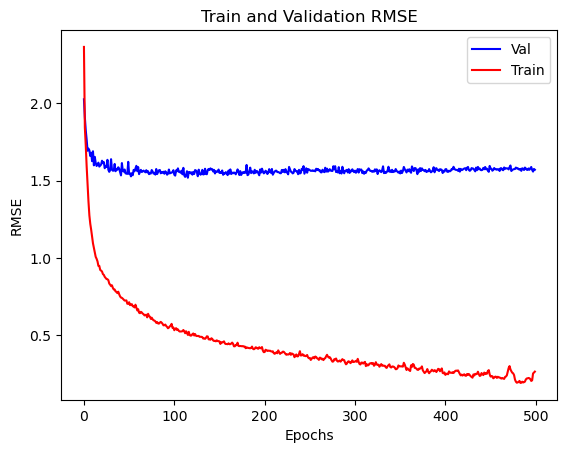

-----------------------------------------------------------------------
TRAINING
RMSE = 0.24299298798186947
MAE 0.1481130707313144
R2 0.9902152708410639
-----------------------------------------------------------------------
TESTING
RMSE = 1.541236001920469
MAE 1.1428556558757428
R2 0.6193104501831213


In [46]:
# Rebounds

print("REBOUNDS")
print("-----------------------------------------------------------------------")


# val split
X_train, X_val, y_train, y_val = train_test_split(np_demo_X_train, np_demo_reb_train, \
                                                        test_size=0.2, random_state=42)
X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
X_val, _, _= ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)                                                        

# Dataloader format
trainset = MLPDataset(X_train, y_train)
valset = MLPDataset(X_val, y_val)
testset = MLPDataset(np_demo_X_test, np_demo_reb_test)

# Run training and validation loop
# Save the quickest model to converge

n_epochs = 30

## Vary batchsizes for smallest run-time
# Sample batchsizes for training  
batchsizes_dict = {16: None, 32: None, 64: None, 128: None, 256: None} # to store runtimes
rts = [] # for runtimes

for B in batchsizes_dict:

    # print(f"Batch size = {B}")

    seeder = 33

    # refresh model for a fair iteration
    model = MLP(n_fts, n_hid)
    model.to(device)
    # for refreshed model
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

    best_rmse = 1000
    train_loss_history = []
    val_loss_history = []

    # time marker
    start = time()
    # Iterate over epochs
    # (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
    for epoch in range(n_epochs):
        # print(f"Epoch {epoch+1} of {n_epochs}")
        seeder += 1
        # Shuffle the data at the start of each epoch (only useful for training set)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=B, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+seeder))
        valloader = torch.utils.data.DataLoader(valset, batch_size=B, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+seeder))
        
        train_loss, train_pred = train(model, trainloader, criterion, optimizer, device, disable=True) # Train
        val_loss, val_pred = validate(model, valloader, criterion, device, disable=True) # Validate
        # mark the end of this epoch's training
        runtime = time() - start
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        Converged = False
        if val_loss < best_rmse: # Save best model
            # print("Updating best model")
            best_loss = val_loss
            # torch.save(model.state_dict(), "best_model_pts.pt") # saving model parameters ("state_dict") saves memory
        if val_loss <= 2 and train_loss <= 2: # convergence
            runtime_model = runtime
            Converged = True
            # print("Attained Stopping Condition")
            break
    if Converged:
        rts.append(runtime_model)
    else:
        rts.append(runtime)
    
    # print("-----------------------------------------------------------------------")

# Complete the dictionary
for key, val in zip(batchsizes_dict, rts):
    batchsizes_dict[key] = round(val, 3)

B_opt = min(batchsizes_dict, key=batchsizes_dict.get)
print(f"Batch size of {B_opt} converges the fastest")

# Run training and validation loop
# Save the best model 
n_epochs = 100
epochs = torch.arange(n_epochs)
best_loss = 1000

## Define grid for hyperparameter optimization
lrs = [1e-3, 1e-2, 1e-1] 
reg_vals = [1e-4, 1e-3, 1e-2]

lr_opt = 0
reg_val_opt = 0

for lr in lrs:
    for reg_val in reg_vals:
        # print(f"Learning rate = {lr} and Lambda = {reg_val}")

        model = MLP(n_fts=n_fts, n_hid=n_hid)
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

        # (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
        for epoch in range(n_epochs): # Iterate over epochs
            # if (epoch+1)%10 == 0:
                # print(f"Epoch {epoch+1} of {n_epochs}")
            # Shuffle the data at the start of each epoch (only useful for training set)
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=B_opt, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+epoch))
            valloader = torch.utils.data.DataLoader(valset, batch_size=B_opt, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+epoch))
            
            train_loss, train_pred = train(model, trainloader, criterion, optimizer, device) # Train
            val_loss, val_pred = validate(model, valloader, criterion, device) # Validate
            
        if val_loss < best_loss: # Save best model
            best_loss = val_loss
            lr_opt = lr
            reg_val_opt = reg_val
            # torch.save(model.state_dict(), "best_model_pts.pt") # saving model parameters ("state_dict") saves memory

        # print("-------------------------------------------------------------------------------------")

## Report Best Hyperparameters from Grid Search
print("Best Model Training Hyperparameters:")
print(f"Learning Rate = {lr_opt}\nLambda = {reg_val_opt}")

# Run training and validation loop
# Save the best model
n_epochs = 500

seeder = 33

model = MLP(n_fts=n_fts, n_hid=n_hid)
model.to(device)
# for refreshed model
optimizer = optim.AdamW(model.parameters(), lr=lr_opt, weight_decay=reg_val_opt)

best_loss = 1000
val_list = []
train_list = []
# Iterate over epochs
# (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
for epoch in range(n_epochs):
    # if (epoch+1)%100 == 0:
        # print(f"Epoch {epoch+1} of {n_epochs}")

    seeder += 1
    # Shuffle the data at the start of each epoch (only useful for training set)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=B_opt, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+seeder))
    valloader = torch.utils.data.DataLoader(valset, batch_size=B_opt, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+seeder))
    
    train_loss, train_pred = train(model, trainloader, criterion, optimizer, device, disable=True) # Train
    val_loss, val_pred = validate(model, valloader, criterion, device, disable=True) # Validate
    train_list.append(train_loss)
    val_list.append(val_loss)
    
    if val_loss < best_loss: # best val accuracy over epochs
        best_loss = val_loss
        # print("Updating best model")
        torch.save(model.state_dict(), "NN_Demo_best_model_reb.pt")

plt.figure()
plt.plot(range(n_epochs), val_list, color='blue')
plt.plot(range(n_epochs), train_list, color='red')
plt.title("Train and Validation RMSE")
plt.legend(["Val", "Train"])
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

# Metrics

mlp = MLP(n_fts=n_fts, n_hid=n_hid)
mlp.load_state_dict(torch.load("NN_Demo_best_model_reb.pt"))

trainloader = DataLoader(trainset, batch_size=B_opt, shuffle=False)
err, y_train_pred = validate(model, trainloader, criterion, device)
y_train_pred = y_train_pred.reshape(len(y_train_pred),)

print("-----------------------------------------------------------------------")
print("TRAINING")
print("RMSE =", mean_squared_error(y_train, y_train_pred, squared=False))
print("MAE", mean_absolute_error(y_train, y_train_pred))
print("R2", r2_score(y_train, y_train_pred))
print("-----------------------------------------------------------------------")

testloader = DataLoader(testset, batch_size=B_opt, shuffle=False)
err, y_test_pred = validate(model, testloader, criterion, device)
y_test_pred = y_test_pred.reshape(len(y_test_pred),)
y_test = np_demo_reb_test

print("TESTING")
print("RMSE =", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE", mean_absolute_error(y_test, y_test_pred))
print("R2", r2_score(y_test, y_test_pred))

#### (c) For Assists

ASSISTS
-----------------------------------------------------------------------
Batch size of 256 converges the fastest
Best Model Training Hyperparameters:
Learning Rate = 0.01
Lambda = 0.0001


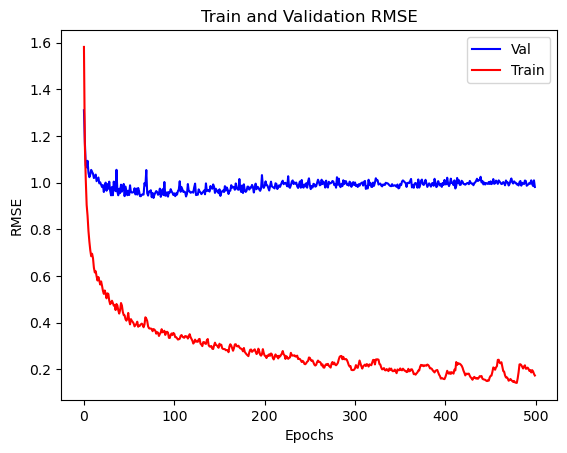

-----------------------------------------------------------------------
TRAINING
RMSE = 0.16630184809204912
MAE 0.09956759037593053
R2 0.9912875037946594
-----------------------------------------------------------------------
TESTING
RMSE = 1.009714768605582
MAE 0.7089541153905838
R2 0.6953379020519759


In [43]:
# Assists

print("ASSISTS")
print("-----------------------------------------------------------------------")


# val split
X_train, X_val, y_train, y_val = train_test_split(np_demo_X_train, np_demo_ast_train, \
                                                        test_size=0.2, random_state=42)
X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)

# Dataloader format
trainset = MLPDataset(X_train, y_train)
valset = MLPDataset(X_val, y_val)
testset = MLPDataset(np_demo_X_test, np_demo_ast_test)

# Run training and validation loop
# Save the quickest model to converge

n_epochs = 30

## Vary batchsizes for smallest run-time
# Sample batchsizes for training  
batchsizes_dict = {16: None, 32: None, 64: None, 128: None, 256: None} # to store runtimes
rts = [] # for runtimes

for B in batchsizes_dict:

    # print(f"Batch size = {B}")

    seeder = 33

    # refresh model for a fair iteration
    model = MLP(n_fts, n_hid)
    model.to(device)
    # for refreshed model
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

    best_rmse = 1000
    train_loss_history = []
    val_loss_history = []

    # time marker
    start = time()
    # Iterate over epochs
    # (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
    for epoch in range(n_epochs):
        # print(f"Epoch {epoch+1} of {n_epochs}")
        seeder += 1
        # Shuffle the data at the start of each epoch (only useful for training set)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=B, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+seeder))
        valloader = torch.utils.data.DataLoader(valset, batch_size=B, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+seeder))
        
        train_loss, train_pred = train(model, trainloader, criterion, optimizer, device, disable=True) # Train
        val_loss, val_pred = validate(model, valloader, criterion, device, disable=True) # Validate
        # mark the end of this epoch's training
        runtime = time() - start
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        Converged = False
        if val_loss < best_rmse: # Save best model
            # print("Updating best model")
            best_loss = val_loss
            # torch.save(model.state_dict(), "best_model_pts.pt") # saving model parameters ("state_dict") saves memory
        if val_loss <= 1 and train_loss <= 1: # convergence
            runtime_model = runtime
            Converged = True
            # print("Attained Stopping Condition")
            break
    if Converged:
        rts.append(runtime_model)
    else:
        rts.append(runtime)
    
    # print("-----------------------------------------------------------------------")

# Complete the dictionary
for key, val in zip(batchsizes_dict, rts):
    batchsizes_dict[key] = round(val, 3)

B_opt = min(batchsizes_dict, key=batchsizes_dict.get)
print(f"Batch size of {B_opt} converges the fastest")

# Run training and validation loop
# Save the best model 
n_epochs = 100
epochs = torch.arange(n_epochs)
best_loss = 1000

## Define grid for hyperparameter optimization
lrs = [1e-3, 1e-2, 1e-1] 
reg_vals = [1e-4, 1e-3, 1e-2]

lr_opt = 0
reg_val_opt = 0

for lr in lrs:
    for reg_val in reg_vals:
        # print(f"Learning rate = {lr} and Lambda = {reg_val}")

        model = MLP(n_fts=n_fts, n_hid=n_hid)
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

        # (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
        for epoch in range(n_epochs): # Iterate over epochs
            # if (epoch+1)%10 == 0:
                # print(f"Epoch {epoch+1} of {n_epochs}")
            # Shuffle the data at the start of each epoch (only useful for training set)
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=B_opt, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+epoch))
            valloader = torch.utils.data.DataLoader(valset, batch_size=B_opt, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+epoch))
            
            train_loss, train_pred = train(model, trainloader, criterion, optimizer, device) # Train
            val_loss, val_pred = validate(model, valloader, criterion, device) # Validate
            
        if val_loss < best_loss: # Save best model
            best_loss = val_loss
            lr_opt = lr
            reg_val_opt = reg_val
            # torch.save(model.state_dict(), "best_model_pts.pt") # saving model parameters ("state_dict") saves memory

        # print("-------------------------------------------------------------------------------------")

## Report Best Hyperparameters from Grid Search
print("Best Model Training Hyperparameters:")
print(f"Learning Rate = {lr_opt}\nLambda = {reg_val_opt}")

# Run training and validation loop
# Save the best model
n_epochs = 500

seeder = 33

model = MLP(n_fts=n_fts, n_hid=n_hid)
model.to(device)
# for refreshed model
optimizer = optim.AdamW(model.parameters(), lr=lr_opt, weight_decay=reg_val_opt)

best_loss = 1000
val_list = []
train_list = []
# Iterate over epochs
# (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
for epoch in range(n_epochs):
    # if (epoch+1)%100 == 0:
        # print(f"Epoch {epoch+1} of {n_epochs}")

    seeder += 1
    # Shuffle the data at the start of each epoch (only useful for training set)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=B_opt, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+seeder))
    valloader = torch.utils.data.DataLoader(valset, batch_size=B_opt, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+seeder))
    
    train_loss, train_pred = train(model, trainloader, criterion, optimizer, device, disable=True) # Train
    val_loss, val_pred = validate(model, valloader, criterion, device, disable=True) # Validate
    train_list.append(train_loss)
    val_list.append(val_loss)
    
    if val_loss < best_loss: # best val accuracy over epochs
        best_loss = val_loss
        # print("Updating best model")
        loss_train = train_loss
        y_val_pred = val_pred
        torch.save(model.state_dict(), "NN_Demo_best_model_ast.pt")

plt.figure()
plt.plot(range(n_epochs), val_list, color='blue')
plt.plot(range(n_epochs), train_list, color='red')
plt.title("Train and Validation RMSE")
plt.legend(["Val", "Train"])
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

# Metrics

mlp = MLP(n_fts=n_fts, n_hid=n_hid)
mlp.load_state_dict(torch.load("NN_Demo_best_model_ast.pt"))

trainloader = DataLoader(trainset, batch_size=B_opt, shuffle=False)
err, y_train_pred = validate(model, trainloader, criterion, device)
y_train_pred = y_train_pred.reshape(len(y_train_pred),)

print("-----------------------------------------------------------------------")
print("TRAINING")
print("RMSE =", mean_squared_error(y_train, y_train_pred, squared=False))
print("MAE", mean_absolute_error(y_train, y_train_pred))
print("R2", r2_score(y_train, y_train_pred))
print("-----------------------------------------------------------------------")

testloader = DataLoader(testset, batch_size=B_opt, shuffle=False)
err, y_test_pred = validate(model, testloader, criterion, device)
y_test_pred = y_test_pred.reshape(len(y_test_pred),)
y_test = np_demo_ast_test

print("TESTING")
print("RMSE =", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE", mean_absolute_error(y_test, y_test_pred))
print("R2", r2_score(y_test, y_test_pred))

## II - Regression: Stastistical Figures

### Preprocessing

In [47]:
# Read into the training dataframe
df_pre = pd.read_csv('NBA_player_datasets/NBA_pre_seasons.csv', index_col=[0])
df_pre.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,27,...,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,24,...,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,58,...,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,9,...,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,10,...,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97


In [48]:
# Clean the training dataframe
df_pre_cleaned = Df_Cleaner(df_pre)
df_pre_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11160 entries, 0 to 11159
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   team_abbreviation  11160 non-null  object 
 1   age                11160 non-null  float64
 2   player_height      11160 non-null  float64
 3   player_weight      11160 non-null  float64
 4   college            11160 non-null  object 
 5   country            11160 non-null  object 
 6   draft_round        11160 non-null  object 
 7   gp                 11160 non-null  int64  
 8   pts                11160 non-null  float64
 9   reb                11160 non-null  float64
 10  ast                11160 non-null  float64
 11  net_rating         11160 non-null  float64
 12  oreb_pct           11160 non-null  float64
 13  dreb_pct           11160 non-null  float64
 14  usg_pct            11160 non-null  float64
 15  ts_pct             11160 non-null  float64
 16  ast_pct            111

In [49]:
# Perform Preprocessing
df_pre_preproc = Df_RegOneHot(df_pre_cleaned)
df_pre_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11160 entries, 0 to 11159
Columns: 492 entries, age to draft_stage_Undrafted
dtypes: float64(12), int64(2), uint8(478)
memory usage: 6.4 MB


In [50]:
# Read into the test dataframe
df_curr = pd.read_csv('NBA_player_datasets/NBA_recent2_seasons.csv', index_col=[0])
df_curr.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
11160,Landry Shamet,BKN,24.0,193.04,86.18248,Wichita State,USA,2018,1,26,...,9.3,1.8,1.6,1.1,0.008,0.067,0.164,0.578,0.097,2020-21
11161,Langston Galloway,PHX,29.0,185.42,90.71840,St. Joseph's (PA),USA,Undrafted,Undrafted,Undrafted,...,4.8,1.1,0.7,3.2,0.017,0.080,0.163,0.605,0.080,2020-21
11162,Larry Nance Jr.,CLE,28.0,200.66,111.13004,Wyoming,USA,2015,1,27,...,9.3,6.7,3.1,-5.6,0.049,0.169,0.139,0.557,0.145,2020-21
11163,Lauri Markkanen,CHI,24.0,213.36,108.86208,Arizona,Finland,2017,1,7,...,13.6,5.3,0.9,-2.8,0.027,0.173,0.197,0.619,0.051,2020-21
11164,LeBron James,LAL,36.0,205.74,113.39800,None,USA,2003,1,1,...,25.0,7.7,7.8,9.2,0.020,0.202,0.310,0.602,0.394,2020-21


In [51]:
# Clean the training dataframe
df_curr_cleaned = Df_Cleaner(df_curr)
df_curr_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1145 entries, 11160 to 12304
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   team_abbreviation  1145 non-null   object 
 1   age                1145 non-null   float64
 2   player_height      1145 non-null   float64
 3   player_weight      1145 non-null   float64
 4   college            1145 non-null   object 
 5   country            1145 non-null   object 
 6   draft_round        1145 non-null   object 
 7   gp                 1145 non-null   int64  
 8   pts                1145 non-null   float64
 9   reb                1145 non-null   float64
 10  ast                1145 non-null   float64
 11  net_rating         1145 non-null   float64
 12  oreb_pct           1145 non-null   float64
 13  dreb_pct           1145 non-null   float64
 14  usg_pct            1145 non-null   float64
 15  ts_pct             1145 non-null   float64
 16  ast_pct            

In [52]:
# Perform Preprocessing
df_curr_preproc = Df_RegOneHot(df_curr_cleaned)
df_curr_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1145 entries, 11160 to 12304
Columns: 274 entries, age to draft_stage_Undrafted
dtypes: float64(12), int64(2), uint8(260)
memory usage: 424.9 KB


### Features and Labels

In [53]:
# Separate X and y from train data
df_stat_X_train = df_pre_preproc[['gp', 'net_rating', 'oreb_pct', 'dreb_pct',\
                                'usg_pct', 'ts_pct', 'ast_pct', 'Experience']].copy()
df_stat_y_train = df_pre_preproc[['pts', 'reb', 'ast']].copy()

# Separate X and y from test data
df_stat_X_test = df_curr_preproc[['gp', 'net_rating', 'oreb_pct', 'dreb_pct',\
                                'usg_pct', 'ts_pct', 'ast_pct', 'Experience']].copy()
df_stat_y_test = df_curr_preproc[['pts', 'reb', 'ast']].copy()


# Convert to numpy arrays for ML
np_stat_X_train, np_stat_X_test = df_stat_X_train.to_numpy(), df_stat_X_test.to_numpy()
np_stat_y_train, np_stat_y_test = df_stat_y_train.to_numpy(), df_stat_y_test.to_numpy()

In [54]:
np_stat_X_train.shape, np_stat_y_train.shape

((11160, 8), (11160, 3))

In [55]:
# For the non one-hot encoded features
marker = 8

In [56]:
np_stat_X1_train, mn_X, rng_X = ScaleCols(X=np_stat_X_train, marker=marker)
np_stat_X_test, _, _ = ScaleCols(X=np_stat_X_test, marker=marker)
np_stat_X_test.shape, np_stat_y_test.shape

((1145, 8), (1145, 3))

In [57]:
np_stat_pts_train, np_stat_pts_test = np_stat_y_train[:, 0], np_stat_y_test[:, 0]
np_stat_reb_train, np_stat_reb_test = np_stat_y_train[:, 1], np_stat_y_test[:, 1]
np_stat_ast_train, np_stat_ast_test = np_stat_y_train[:, 2], np_stat_y_test[:, 2]

### (i) Trivial System

In [58]:
## Trivial System

print("TRAINING")
trivial_pts = np.ones_like(np_stat_pts_train) * np.mean(np_stat_pts_train)
trivial_reb = np.ones_like(np_stat_reb_train) * np.mean(np_stat_reb_train)
trivial_ast = np.ones_like(np_stat_ast_train) * np.mean(np_stat_ast_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_train, trivial_pts, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_train, trivial_reb, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_train, trivial_ast, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_train, trivial_pts)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_train, trivial_reb)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_train, trivial_ast)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_train, trivial_pts)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_train, trivial_reb)}')
print(f'R2 for assists = {r2_score(np_stat_ast_train, trivial_ast)}')
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print("TESTING")
trivial_pts = np.ones_like(np_stat_pts_test) * np.mean(np_stat_pts_train)
trivial_reb = np.ones_like(np_stat_reb_test) * np.mean(np_stat_reb_train)
trivial_ast = np.ones_like(np_stat_ast_test) * np.mean(np_stat_ast_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_test, trivial_pts, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_test, trivial_reb, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_test, trivial_ast, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_test, trivial_pts)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_test, trivial_reb)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_test, trivial_ast)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_test, trivial_pts)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_test, trivial_reb)}')
print(f'R2 for assists = {r2_score(np_stat_ast_test, trivial_ast)}')

TRAINING
RMSE for points = 5.926879268132353
RMSE for rebounds = 2.491954195627254
RMSE for assists = 1.788082612288932
-------------------------------------------------------------------------------------
MAE for points = 4.728497832119321
MAE for rebounds = 1.9120441348389663
MAE for assists = 1.3121881383204226
-------------------------------------------------------------------------------------
R2 for points = 0.0
R2 for rebounds = 0.0
R2 for assists = 0.0
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 6.423714800850231
RMSE for rebounds = 2.3989838306327584
RMSE for assists = 1.8519137066875686
-------------------------------------------------------------------------------------
MAE for points = 4.916616370067771
MAE for rebounds = 1.821328786527054
MAE for assists = 1.3339607691224118
-----------------------------------------------

### (ii) Baseline Systems

#### (a) 1NN

In [59]:
## Baseline system - KNN with K = 1

# Points
knn_pts = KNeighborsRegressor(n_neighbors=1)
knn_pts.fit(np_stat_X1_train, np_stat_pts_train)
# Rebounds
knn_reb = KNeighborsRegressor(n_neighbors=1)
knn_reb.fit(np_stat_X1_train, np_stat_reb_train)
# Assists
knn_ast = KNeighborsRegressor(n_neighbors=1)
knn_ast.fit(np_stat_X1_train, np_stat_ast_train)

print("TRAINING")
pts_1nn = knn_pts.predict(np_stat_X1_train)
reb_1nn = knn_reb.predict(np_stat_X1_train)
ast_1nn = knn_ast.predict(np_stat_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_train, pts_1nn, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_train, reb_1nn, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_train, ast_1nn, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_train, pts_1nn)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_train, reb_1nn)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_train, ast_1nn)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_train, pts_1nn)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_train, reb_1nn)}')
print(f'R2 for assists = {r2_score(np_stat_ast_train, ast_1nn)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print("TESTING")
pts_1nn = knn_pts.predict(np_stat_X_test)
reb_1nn = knn_reb.predict(np_stat_X_test)
ast_1nn = knn_ast.predict(np_stat_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_test, pts_1nn, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_test, reb_1nn, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_test, ast_1nn, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_test, pts_1nn)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_test, reb_1nn)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_test, ast_1nn)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_test, pts_1nn)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_test, reb_1nn)}')
print(f'R2 for assists = {r2_score(np_stat_ast_test, ast_1nn)}')

TRAINING
RMSE for points = 0.0
RMSE for rebounds = 0.0
RMSE for assists = 0.0
-------------------------------------------------------------------------------------
MAE for points = 0.0
MAE for rebounds = 0.0
MAE for assists = 0.0
-------------------------------------------------------------------------------------
R2 for points = 1.0
R2 for rebounds = 1.0
R2 for assists = 1.0
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 4.141575338951304
RMSE for rebounds = 2.2835867749993572
RMSE for assists = 0.9745270939119952
-------------------------------------------------------------------------------------
MAE for points = 3.0321397379912662
MAE for rebounds = 1.545414847161572
MAE for assists = 0.6558078602620088
-------------------------------------------------------------------------------------
R2 for points = 0.5823666119967608
R2 for rebo

#### (b) Simple Linear Regression

In [60]:
## Baseline system - Linear Regression with lambda = 0

# Points
lin_pts = LinearRegression()
lin_pts.fit(np_stat_X1_train, np_stat_pts_train)
# Rebounds
lin_reb = LinearRegression()
lin_reb.fit(np_stat_X1_train, np_stat_reb_train)
# Assists
lin_ast = LinearRegression()
lin_ast.fit(np_stat_X1_train, np_stat_ast_train)

print('TRAINING')
pts_lin = lin_pts.predict(np_stat_X1_train)
reb_lin = lin_reb.predict(np_stat_X1_train)
ast_lin = lin_ast.predict(np_stat_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_train, pts_lin, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_train, reb_lin, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_train, ast_lin, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_train, pts_lin)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_train, reb_lin)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_train, ast_lin)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_train, pts_lin)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_train, reb_lin)}')
print(f'R2 for assists = {r2_score(np_stat_ast_train, ast_lin)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
pts_lin = lin_pts.predict(np_stat_X_test)
reb_lin = lin_reb.predict(np_stat_X_test)
ast_lin = lin_ast.predict(np_stat_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_test, pts_lin, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_test, reb_lin, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_test, ast_lin, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_test, pts_lin)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_test, reb_lin)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_test, ast_lin)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_test, pts_lin)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_test, reb_lin)}')
print(f'R2 for assists = {r2_score(np_stat_ast_test, ast_lin)}')

TRAINING
RMSE for points = 3.433607469337853
RMSE for rebounds = 1.5204122081832727
RMSE for assists = 0.8976631851235767
-------------------------------------------------------------------------------------
MAE for points = 2.6141130647942386
MAE for rebounds = 1.1257734814250184
MAE for assists = 0.6137033681864889
-------------------------------------------------------------------------------------
R2 for points = 0.6643789986861861
R2 for rebounds = 0.6277432464252508
R2 for assists = 0.7479703312876351
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 5.471556878680649
RMSE for rebounds = 2.691422963258162
RMSE for assists = 1.03262242460049
-------------------------------------------------------------------------------------
MAE for points = 3.6964802573673703
MAE for rebounds = 1.8878324946440086
MAE for assists = 0.6820338538897348


### (iii) Non-Probabilistic Models

#### (a) Multinomial Regression

In [61]:
# best_params_pts = {'degree': 1, 'lamda': 0}
# best_params_reb = {'degree': 1, 'lamda': 0}
# best_params_ast = {'degree': 1, 'lamda': 0}
best_params_pts = {'degree': 6, 'lamda': 3}
best_params_reb = {'degree': 6, 'lamda': 10}
best_params_ast = {'degree': 5, 'lamda': 1}

# # grids for search 
# degrees = [3, 4, 5, 6, 7]
# lamdas = [0.3, 1, 3, 10, 30]

# # to isolate best model
# rmse_pts, r2_pts = 100, 0
# rmse_reb, r2_reb = 100, 0
# rmse_ast, r2_ast = 100, 0

# for degree in degrees:
#     for lamda in lamdas:
#         clf = MSE_Regressor(degree=degree, lamda=lamda, marker=marker)
#         # Use K-fold validation for 5 folds
#         kfold = KFold(n_splits=5)
#         for idx, (train_idx, val_idx) in enumerate(kfold.split(np_stat_X_train)):
#             X_train, X_val = np_stat_X_train[train_idx], np_stat_X_train[val_idx]
#             X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
#             X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)

#             # Points
#             y_train, y_val = np_stat_pts_train[train_idx], np_stat_pts_train[val_idx]
#             clf.fit(X_train, y_train)
#             y_pred = clf.predict(X_val)
#             # Decide on RMSE and R2
#             rmse_1 = mean_squared_error(y_val, y_pred, squared=False)
#             r2_1 = r2_score(y_val, y_pred)
#             if (rmse_1 < rmse_pts):
#                 rmse_pts = rmse_1
#                 r2_pts = r2_1
#                 best_params_pts['degree'] = degree
#                 best_params_pts['lamda'] = lamda

#             # Rebounds
#             y_train, y_val = np_stat_reb_train[train_idx], np_stat_reb_train[val_idx]
#             clf.fit(X_train, y_train)
#             y_pred = clf.predict(X_val)
#             # Decide on RMSE and R2
#             rmse_1 = mean_squared_error(y_val, y_pred, squared=False)
#             r2_1 = r2_score(y_val, y_pred)
#             if (rmse_1 < rmse_reb):
#                 rmse_reb = rmse_1
#                 r2_reb = r2_1
#                 best_params_reb['degree'] = degree
#                 best_params_reb['lamda'] = lamda

#             # Assists
#             y_train, y_val = np_stat_ast_train[train_idx], np_stat_ast_train[val_idx]
#             clf.fit(X_train, y_train)
#             y_pred = clf.predict(X_val)
#             # Decide on RMSE and R2
#             rmse_1 = mean_squared_error(y_val, y_pred, squared=False)
#             r2_1 = r2_score(y_val, y_pred)
#             if (rmse_1 < rmse_ast):
#                 rmse_ast = rmse_1
#                 r2_ast = r2_1
#                 best_params_ast['degree'] = degree
#                 best_params_ast['lamda'] = lamda

In [62]:
print("Best Params for Points =", best_params_pts)
print("Best Params for Rebounds =", best_params_reb)
print("Best Params for Assists =", best_params_ast)

Best Params for Points = {'degree': 6, 'lamda': 3}
Best Params for Rebounds = {'degree': 6, 'lamda': 10}
Best Params for Assists = {'degree': 5, 'lamda': 1}


In [63]:
## Results

# Points
reg_pts = MSE_Regressor(degree=best_params_pts['degree'], lamda=best_params_pts['lamda'], marker=marker)
reg_pts.fit(np_stat_X1_train, np_stat_pts_train)
# Rebounds
reg_reb = MSE_Regressor(degree=best_params_reb['degree'], lamda=best_params_reb['lamda'], marker=marker)
reg_reb.fit(np_stat_X1_train, np_stat_reb_train)
# Assists
reg_ast = MSE_Regressor(degree=best_params_ast['degree'], lamda=best_params_ast['lamda'], marker=marker)
reg_ast.fit(np_stat_X1_train, np_stat_ast_train)

print('TRAINING')
pts_reg = reg_pts.predict(np_stat_X1_train)
reb_reg = reg_reb.predict(np_stat_X1_train)
ast_reg = reg_ast.predict(np_stat_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_train, pts_reg, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_train, reb_reg, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_train, ast_reg, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_train, pts_reg)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_train, reb_reg)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_train, ast_reg)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_train, pts_reg)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_train, reb_reg)}')
print(f'R2 for assists = {r2_score(np_stat_ast_train, ast_reg)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
pts_reg = reg_pts.predict(np_stat_X_test)
reb_reg = reg_reb.predict(np_stat_X_test)
ast_reg = reg_ast.predict(np_stat_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_test, pts_reg, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_test, reb_reg, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_test, ast_reg, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_test, pts_reg)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_test, reb_reg)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_test, ast_reg)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_test, pts_reg)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_test, reb_reg)}')
print(f'R2 for assists = {r2_score(np_stat_ast_test, ast_reg)}')

TRAINING
RMSE for points = 2.8507616854186995
RMSE for rebounds = 1.4009023286685534
RMSE for assists = 0.674252453887643
-------------------------------------------------------------------------------------
MAE for points = 2.184109368798726
MAE for rebounds = 1.0349142501197346
MAE for assists = 0.4475736720931923
-------------------------------------------------------------------------------------
R2 for points = 0.7686499141033809
R2 for rebounds = 0.6839646932482351
R2 for assists = 0.8578097193661606
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 4.322913641926862
RMSE for rebounds = 2.0413086540617966
RMSE for assists = 0.8232040398188997
-------------------------------------------------------------------------------------
MAE for points = 3.349293864508768
MAE for rebounds = 1.5253976612997702
MAE for assists = 0.5782636010093355

#### (b) RBF Kernel Ridge

In [64]:
# Using basis function centers as data points

logs_10 = np.array([0.01, 0.1, 1])
# lamdas = [0.001, 0.01, 0.1]
lamdas = [0.01, 0.1]

best_params_pts = {'gamma': 0,'lamda': 100}
best_params_reb = {'gamma': 0,'lamda': 100}
best_params_ast = {'gamma': 0,'lamda': 100}

# to isolate best model
rmse_pts, r2_pts = 100, 0
rmse_reb, r2_reb = 100, 0
rmse_ast, r2_ast = 100, 0


for lamda in lamdas:
    for factor in logs_10:
        # Use K-fold validation for 5 folds
        kfold = KFold(n_splits=5) # 5-fold cross validation
        pts_rmse_list = []
        reb_rmse_list = []
        ast_rmse_list = []
        # Model Selection for gamma
        fold_gammas = []
        for idx, (train_idx, val_idx) in enumerate(kfold.split(np_stat_X_train)):
            X_train, X_val = np_stat_X_train[train_idx], np_stat_X_train[val_idx]
            X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
            X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)

            # Points
            y_train, y_val = np_stat_pts_train[train_idx], np_stat_pts_train[val_idx]
            reg_pts = RBFNetwork(factor=factor, center_type=1, lamda=lamda, M=len(X_train)) # Define model
            centers = reg_pts.fit(X_train, y_train)                            # Fit, and obtain basis fn centers
            y_pred = reg_pts.predict(X_val)
            pts_rmse_list.append(mean_squared_error(y_val, y_pred, squared=False)) 

            # Rebounds
            y_train, y_val = np_stat_reb_train[train_idx], np_stat_reb_train[val_idx]
            reg_reb = RBFNetwork(factor=factor, center_type=1, lamda=lamda, M=len(X_train)) # Define model
            centers = reg_reb.fit(X_train, y_train)                            # Fit, and obtain basis fn centers
            y_pred = reg_reb.predict(X_val)
            reb_rmse_list.append(mean_squared_error(y_val, y_pred, squared=False)) 

            # Assists
            y_train, y_val = np_stat_ast_train[train_idx], np_stat_ast_train[val_idx]
            reg_ast = RBFNetwork(factor=factor, center_type=1, lamda=lamda, M=len(X_train)) # Define model
            centers = reg_ast.fit(X_train, y_train)                            # Fit, and obtain basis fn centers
            y_pred = reg_ast.predict(X_val)
            ast_rmse_list.append(mean_squared_error(y_val, y_pred, squared=False)) 

        pts_gammas = np.array(fold_gammas[0::3])
        reb_gammas = np.array(fold_gammas[1::3])
        ast_gammas = np.array(fold_gammas[2::3])
        
        # update best lamda for points
        if (np.mean(pts_rmse_list)) < rmse_pts:
            rmse_pts = np.mean(pts_rmse_list)
            best_params_pts['lamda'] = lamda
            best_params_pts['gamma'] = np.mean(pts_gammas)
            best_rbf_pts = reg_pts

        # update best lamda for rebounds
        if (np.mean(reb_rmse_list)) < rmse_reb:
            rmse_reb = np.mean(reb_rmse_list)
            best_params_reb['lamda'] = lamda
            best_params_reb['gamma'] = np.mean(reb_gammas)
            best_rbf_reb = reg_reb

        # update best lamda for assists
        if (np.mean(ast_rmse_list)) < rmse_ast:
            rmse_ast = np.mean(ast_rmse_list)
            best_params_ast['lamda'] = lamda
            best_params_ast['gamma'] = np.mean(ast_gammas)
            best_rbf_ast = reg_ast

print("Best Params for Points =", best_params_pts)
print("Best Params for Rebounds =", best_params_reb)
print("Best Params for Assists =", best_params_ast)

Best Params for Points = {'gamma': 0.223895812845004, 'lamda': 0.01}
Best Params for Rebounds = {'gamma': 0.223895812845004, 'lamda': 0.01}
Best Params for Assists = {'gamma': 0.223895812845004, 'lamda': 0.01}


In [65]:
## Results

# Points
best_rbf_pts.fit(np_stat_X1_train, np_stat_pts_train)
# Rebounds
best_rbf_reb.fit(np_stat_X1_train, np_stat_reb_train)
# Assists
best_rbf_ast.fit(np_stat_X1_train, np_stat_ast_train)

print('TRAINING')
pts_rbf = best_rbf_pts.predict(np_stat_X1_train)
reb_rbf = best_rbf_reb.predict(np_stat_X1_train)
ast_rbf = best_rbf_ast.predict(np_stat_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_train, pts_rbf, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_train, reb_rbf, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_train, ast_rbf, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_train, pts_rbf)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_train, reb_rbf)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_train, ast_rbf)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_train, pts_rbf)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_train, reb_rbf)}')
print(f'R2 for assists = {r2_score(np_stat_ast_train, ast_rbf)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
pts_rbf = best_rbf_pts.predict(np_stat_X_test)
reb_rbf = best_rbf_reb.predict(np_stat_X_test)
ast_rbf = best_rbf_ast.predict(np_stat_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_test, pts_rbf, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_test, reb_rbf, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_test, ast_rbf, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_test, pts_rbf)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_test, reb_rbf)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_test, ast_rbf)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_test, pts_rbf)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_test, reb_rbf)}')
print(f'R2 for assists = {r2_score(np_stat_ast_test, ast_rbf)}')

TRAINING
RMSE for points = 2.6837633395904117
RMSE for rebounds = 1.2518468194528114
RMSE for assists = 0.6813038234563518
-------------------------------------------------------------------------------------
MAE for points = 2.0541999102015795
MAE for rebounds = 0.9173254983971084
MAE for assists = 0.4519456014769052
-------------------------------------------------------------------------------------
R2 for points = 0.7949610963959056
R2 for rebounds = 0.7476389824505162
R2 for assists = 0.8548201001972238
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 4.986495015974349
RMSE for rebounds = 2.877324690718623
RMSE for assists = 0.8269564196295993
-------------------------------------------------------------------------------------
MAE for points = 3.8663460668729943
MAE for rebounds = 2.2107482956786266
MAE for assists = 0.56712854285978

### (iv) Support Vector Machine

In [66]:
## Support Vector Regression

# best_params_pts = {'kernel': 'rbf', 'degree': 1, 'gamma': 10, 'C': 0.1}
# best_params_reb = {'kernel': 'rbf', 'degree': 1, 'gamma': 10, 'C': 0.1}
# best_params_ast = {'kernel': 'rbf', 'degree': 1, 'gamma': 10, 'C': 0.1}
best_params_pts = {'kernel': 'rbf', 'degree': 2, 'gamma': 3, 'C': 0.1}
best_params_reb = {'kernel': 'rbf', 'degree': 2, 'gamma': 3, 'C': 0.1}
best_params_ast = {'kernel': 'rbf', 'degree': 2, 'gamma': 3, 'C': 0.1}

# # grids for search 
# kernels = ['rbf', 'sigmoid', 'poly']
# degrees = [3, 4, 5]
# gammas = [0.3, 1, 3]
# Cs = [0.01, 0.03, 0.1]

# # to isolate best model
# rmse_pts, r2_pts = 100, 0
# rmse_reb, r2_reb = 100, 0
# rmse_ast, r2_ast = 100, 0
# counter = 0

# for kernel in kernels:
#     for gamma in gammas:
#         for C in Cs:
#             for degree in degrees:
#                 Breaker = True
#                 if kernel == 'poly':
#                     Breaker = False
#                 X_train, X_val, y_train, y_val = train_test_split(np_stat_X_train, np_stat_y_train, \
#                                                                     test_size=0.2, random_state=42)
#                 X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
#                 X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
#                 clf = SVR(kernel=kernel, degree=degree, gamma=gamma, C=C)

#                 # Points
#                 pts_train, pts_val = y_train[:, 0], y_val[:, 0]
#                 clf.fit(X_train, pts_train)
#                 pts_pred = clf.predict(X_val)
#                 # Decide on RMSE and R2
#                 rmse_1 = mean_squared_error(pts_val, pts_pred, squared=False)
#                 r2_1 = r2_score(pts_val, pts_pred)
#                 if (rmse_1 < rmse_pts):
#                     rmse_pts = rmse_1
#                     r2_pts = r2_1
#                     best_params_pts['kernel'] = kernel
#                     best_params_pts['degree'] = degree
#                     best_params_pts['gamma'] = gamma
#                     best_params_pts['C'] = C

#                 # Rebounds
#                 reb_train, reb_val = y_train[:, 1], y_val[:, 1]
#                 clf.fit(X_train, reb_train)
#                 reb_pred = clf.predict(X_val)
#                 # Decide on RMSE and R2
#                 rmse_1 = mean_squared_error(reb_val, reb_pred, squared=False)
#                 r2_1 = r2_score(reb_val, reb_pred)
#                 if (rmse_1 < rmse_reb):
#                     rmse_reb = rmse_1
#                     r2_reb = r2_1
#                     best_params_reb['kernel'] = kernel
#                     best_params_reb['degree'] = degree
#                     best_params_reb['gamma'] = gamma
#                     best_params_reb['C'] = C

#                 # Assists
#                 ast_train, ast_val = y_train[:, 2], y_val[:, 2]
#                 clf.fit(X_train, ast_train)
#                 ast_pred = clf.predict(X_val)
#                 # Decide on RMSE and R2
#                 rmse_1 = mean_squared_error(ast_val, ast_pred, squared=False)
#                 r2_1 = r2_score(ast_val, ast_pred)
#                 if (rmse_1 < rmse_ast):
#                     rmse_ast = rmse_1
#                     r2_ast = r2_1
#                     best_params_ast['kernel'] = kernel
#                     best_params_ast['degree'] = degree
#                     best_params_ast['gamma'] = gamma
#                     best_params_ast['C'] = C

#                 if Breaker:
#                     break

print("Best Params for Points =", best_params_pts)
print("Best Params for Rebounds =", best_params_reb)
print("Best Params for Assists =", best_params_ast)

Best Params for Points = {'kernel': 'rbf', 'degree': 2, 'gamma': 3, 'C': 0.1}
Best Params for Rebounds = {'kernel': 'rbf', 'degree': 2, 'gamma': 3, 'C': 0.1}
Best Params for Assists = {'kernel': 'rbf', 'degree': 2, 'gamma': 3, 'C': 0.1}


In [67]:
## Results

# Points
svr_pts = SVR(kernel=best_params_pts['kernel'], degree=best_params_pts['degree'], gamma=best_params_pts['gamma'], C=best_params_pts['C'])
svr_pts.fit(np_stat_X1_train, np_stat_pts_train)
# Rebounds
svr_reb = SVR(kernel=best_params_reb['kernel'], degree=best_params_reb['degree'], gamma=best_params_reb['gamma'], C=best_params_reb['C'])
svr_reb.fit(np_stat_X1_train, np_stat_reb_train)
# Assists
svr_ast = SVR(kernel=best_params_ast['kernel'], degree=best_params_ast['degree'], gamma=best_params_ast['gamma'], C=best_params_ast['C'])
svr_ast.fit(np_stat_X1_train, np_stat_ast_train)

print('TRAINING')
pts_svr = svr_pts.predict(np_stat_X1_train)
reb_svr = svr_reb.predict(np_stat_X1_train)
ast_svr = svr_ast.predict(np_stat_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_train, pts_svr, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_train, reb_svr, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_train, ast_svr, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_train, pts_svr)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_train, reb_svr)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_train, ast_svr)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_train, pts_svr)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_train, reb_svr)}')
print(f'R2 for assists = {r2_score(np_stat_ast_train, ast_svr)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
pts_svr = svr_pts.predict(np_stat_X_test)
reb_svr = svr_reb.predict(np_stat_X_test)
ast_svr = svr_ast.predict(np_stat_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_test, pts_svr, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_test, reb_svr, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_test, ast_svr, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_test, pts_svr)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_test, reb_svr)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_test, ast_svr)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_test, pts_svr)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_test, reb_svr)}')
print(f'R2 for assists = {r2_score(np_stat_ast_test, ast_svr)}')

TRAINING
RMSE for points = 3.1007586377151495
RMSE for rebounds = 1.2877253676693434
RMSE for assists = 0.6847800467507557
-------------------------------------------------------------------------------------
MAE for points = 2.2344013302546455
MAE for rebounds = 0.9006938231479572
MAE for assists = 0.4332170141834274
-------------------------------------------------------------------------------------
R2 for points = 0.726294349637632
R2 for rebounds = 0.7329661042336659
R2 for assists = 0.8533348149447069
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 3.4793718149321977
RMSE for rebounds = 1.709557746293804
RMSE for assists = 0.9395019063566268
-------------------------------------------------------------------------------------
MAE for points = 2.6180472275045124
MAE for rebounds = 1.3838522350744697
MAE for assists = 0.57605138782476

### (v) Probabilistic Models

#### (a) KNN

In [68]:
## Probabilistic Regression - KNN

# best_params_pts = {'K': 1}
# best_params_reb = {'K': 1}
# best_params_ast = {'K': 1}
best_params_pts = {'K': 15}
best_params_reb = {'K': 25}
best_params_ast = {'K': 15}

# grids for search 
Ks = [5, 10, 15, 20, 25, 30]

# to isolate best model
rmse_pts, r2_pts = 100, 0
rmse_reb, r2_reb = 100, 0
rmse_ast, r2_ast = 100, 0

for K in Ks:
    X_train, X_val, y_train, y_val = train_test_split(np_stat_X_train, np_stat_y_train, \
                                                        test_size=0.2, random_state=42)
    X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
    X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
    clf = KNeighborsRegressor(n_neighbors=K, weights='distance')

    # Points
    pts_train, pts_val = y_train[:, 0], y_val[:, 0]
    clf.fit(X_train, pts_train)
    pts_pred = clf.predict(X_val)
    # Decide on RMSE and R2
    rmse_1 = mean_squared_error(pts_val, pts_pred, squared=False)
    r2_1 = r2_score(pts_val, pts_pred)
    if (rmse_1 < rmse_pts):
        rmse_pts = rmse_1
        r2_pts = r2_1
        best_params_pts['K'] = K
        
    # Rebounds
    reb_train, reb_val = y_train[:, 1], y_val[:, 1]
    clf.fit(X_train, reb_train)
    reb_pred = clf.predict(X_val)
    # Decide on RMSE and R2
    rmse_1 = mean_squared_error(reb_val, reb_pred, squared=False)
    r2_1 = r2_score(reb_val, reb_pred)
    if (rmse_1 < rmse_reb):
        rmse_reb = rmse_1
        r2_reb = r2_1
        best_params_reb['K'] = K

    # Assists
    ast_train, ast_val = y_train[:, 2], y_val[:, 2]
    clf.fit(X_train, ast_train)
    ast_pred = clf.predict(X_val)
    # Decide on RMSE and R2
    rmse_1 = mean_squared_error(ast_val, ast_pred, squared=False)
    r2_1 = r2_score(ast_val, ast_pred)
    if (rmse_1 < rmse_ast):
        rmse_ast = rmse_1
        r2_ast = r2_1
        best_params_ast['K'] = K

print("Best Params for Points =", best_params_pts)
print("Best Params for Rebounds =", best_params_reb)
print("Best Params for Assists =", best_params_ast)

Best Params for Points = {'K': 15}
Best Params for Rebounds = {'K': 15}
Best Params for Assists = {'K': 15}


In [69]:
## Results

# Points
knn_pts = KNeighborsRegressor(n_neighbors=best_params_pts['K'], weights='distance')
knn_pts.fit(np_stat_X1_train, np_stat_pts_train)
# Rebounds
knn_reb = KNeighborsRegressor(n_neighbors=best_params_reb['K'], weights='distance')
knn_reb.fit(np_stat_X1_train, np_stat_reb_train)
# Assists
knn_ast = KNeighborsRegressor(n_neighbors=best_params_ast['K'], weights='distance')
knn_ast.fit(np_stat_X1_train, np_stat_ast_train)

print("TRAINING")
pts_1nn = knn_pts.predict(np_stat_X1_train)
reb_1nn = knn_reb.predict(np_stat_X1_train)
ast_1nn = knn_ast.predict(np_stat_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_train, pts_1nn, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_train, reb_1nn, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_train, ast_1nn, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_train, pts_1nn)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_train, reb_1nn)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_train, ast_1nn)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_train, pts_1nn)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_train, reb_1nn)}')
print(f'R2 for assists = {r2_score(np_stat_ast_train, ast_1nn)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print("TESTING")
pts_1nn = knn_pts.predict(np_stat_X_test)
reb_1nn = knn_reb.predict(np_stat_X_test)
ast_1nn = knn_ast.predict(np_stat_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_test, pts_1nn, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_test, reb_1nn, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_test, ast_1nn, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_test, pts_1nn)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_test, reb_1nn)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_test, ast_1nn)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_test, pts_1nn)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_test, reb_1nn)}')
print(f'R2 for assists = {r2_score(np_stat_ast_test, ast_1nn)}')

TRAINING
RMSE for points = 0.0
RMSE for rebounds = 0.0
RMSE for assists = 0.0
-------------------------------------------------------------------------------------
MAE for points = 0.0
MAE for rebounds = 0.0
MAE for assists = 0.0
-------------------------------------------------------------------------------------
R2 for points = 1.0
R2 for rebounds = 1.0
R2 for assists = 1.0
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 2.949354027753609
RMSE for rebounds = 1.4338652871046083
RMSE for assists = 0.8529772479705825
-------------------------------------------------------------------------------------
MAE for points = 2.117241662877632
MAE for rebounds = 1.0388615862669002
MAE for assists = 0.5488976169012513
-------------------------------------------------------------------------------------
R2 for points = 0.7882039323368808
R2 for rebo

#### (b) Bayesian with Gaussian Prior

In [70]:
## Probabilistic Regression - Bayesian with Gaussian Prior

# best_params_pts = {'a1': 1, 'lam1': 1, 'a2': 1, 'lam2': 1}
# best_params_reb = {'a1': 1, 'lam1': 1, 'a2': 1, 'lam2': 1}
# best_params_ast = {'a1': 1, 'lam1': 1, 'a2': 1, 'lam2': 1}
best_params_pts = {'a1': 1e-6, 'lam1': 1, 'a2': 1, 'lam2': 1}
best_params_reb = {'a1': 1e-6, 'lam1': 1, 'a2': 1, 'lam2': 1}
best_params_ast = {'a1': 1e-6, 'lam1': 1, 'a2': 1, 'lam2': 1e-6}

# # grids for search 
# alphas_1 = [1e-6, 1e-4, 1e-2, 1]
# alphas_2 = [1e-6, 1e-4, 1e-2, 1]
# lamdas_1 = [1e-6, 1e-4, 1e-2, 1]
# lamdas_2 = [1e-6, 1e-4, 1e-2, 1]

# # to isolate best model
# rmse_pts, r2_pts = 100, 0
# rmse_reb, r2_reb = 100, 0
# rmse_ast, r2_ast = 100, 0

# for a1 in alphas_1:
#     for a2 in alphas_2:
#         for lam1 in lamdas_1:
#             for lam2 in lamdas_2:
#                 X_train, X_val, y_train, y_val = train_test_split(np_stat_X_train, np_stat_y_train, \
#                                                                   test_size=0.2, random_state=42)
#                 X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
#                 X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
#                 clf = ARDRegression(alpha_1=a1, alpha_2=a2, lambda_1=lam1, lambda_2=lam2)

#                 # Points
#                 pts_train, pts_val = y_train[:, 0], y_val[:, 0]
#                 clf.fit(X_train, pts_train)
#                 pts_pred = clf.predict(X_val)
#                 # Decide on RMSE and R2
#                 rmse_1 = mean_squared_error(pts_val, pts_pred, squared=False)
#                 r2_1 = r2_score(pts_val, pts_pred)
#                 if (rmse_1 < rmse_pts):
#                     rmse_pts = rmse_1
#                     r2_pts = r2_1
#                     best_params_pts['a1'] = a1
#                     best_params_pts['a2'] = a2
#                     best_params_pts['lam1'] = lam1
#                     best_params_pts['lam2'] = lam2

#                 # Rebounds
#                 reb_train, reb_val = y_train[:, 1], y_val[:, 1]
#                 clf.fit(X_train, reb_train)
#                 reb_pred = clf.predict(X_val)
#                 # Decide on RMSE and R2
#                 rmse_1 = mean_squared_error(reb_val, reb_pred, squared=False)
#                 r2_1 = r2_score(reb_val, reb_pred)
#                 if (rmse_1 < rmse_reb):
#                     rmse_reb = rmse_1
#                     r2_reb = r2_1
#                     best_params_reb['a1'] = a1
#                     best_params_reb['a2'] = a2
#                     best_params_reb['lam1'] = lam1
#                     best_params_reb['lam2'] = lam2

#                 # Assists
#                 ast_train, ast_val = y_train[:, 2], y_val[:, 2]
#                 clf.fit(X_train, ast_train)
#                 ast_pred = clf.predict(X_val)
#                 # Decide on RMSE and R2
#                 rmse_1 = mean_squared_error(ast_val, ast_pred, squared=False)
#                 r2_1 = r2_score(ast_val, ast_pred)
#                 if (rmse_1 < rmse_ast):
#                     rmse_ast = rmse_1
#                     r2_ast = r2_1
#                     best_params_ast['a1'] = a1
#                     best_params_ast['a2'] = a2
#                     best_params_ast['lam1'] = lam1
#                     best_params_ast['lam2'] = lam2

print("Best Params for Points =", best_params_pts)
print("Best Params for Rebounds =", best_params_reb)
print("Best Params for Assists =", best_params_ast)

Best Params for Points = {'a1': 1e-06, 'lam1': 1, 'a2': 1, 'lam2': 1}
Best Params for Rebounds = {'a1': 1e-06, 'lam1': 1, 'a2': 1, 'lam2': 1}
Best Params for Assists = {'a1': 1e-06, 'lam1': 1, 'a2': 1, 'lam2': 1e-06}


In [71]:
## Results

# Points
clf_pts = ARDRegression(alpha_1=best_params_pts['a1'], alpha_2=best_params_pts['a2'], \
                        lambda_1=best_params_pts['lam1'], lambda_2=best_params_pts['lam2'])
clf_pts.fit(np_stat_X1_train, np_stat_pts_train)
# Rebounds
clf_reb = ARDRegression(alpha_1=best_params_reb['a1'], alpha_2=best_params_reb['a2'], \
                        lambda_1=best_params_reb['lam1'], lambda_2=best_params_reb['lam2'])
clf_reb.fit(np_stat_X1_train, np_stat_reb_train)
# Assists
clf_ast = ARDRegression(alpha_1=best_params_ast['a1'], alpha_2=best_params_ast['a2'], \
                        lambda_1=best_params_ast['lam1'], lambda_2=best_params_ast['lam2'])
clf_ast.fit(np_stat_X1_train, np_stat_ast_train)

print('TRAINING')
pts_bay = clf_pts.predict(np_stat_X1_train)
reb_bay = clf_reb.predict(np_stat_X1_train)
ast_bay = clf_ast.predict(np_stat_X1_train)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_train, pts_bay, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_train, reb_bay, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_train, ast_bay, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_train, pts_bay)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_train, reb_bay)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_train, ast_bay)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_train, pts_bay)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_train, reb_bay)}')
print(f'R2 for assists = {r2_score(np_stat_ast_train, ast_bay)}')

print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
pts_bay = clf_pts.predict(np_stat_X_test)
reb_bay = clf_reb.predict(np_stat_X_test)
ast_bay = clf_ast.predict(np_stat_X_test)
# RMSE
print(f'RMSE for points = {mean_squared_error(np_stat_pts_test, pts_bay, squared=False)}')
print(f'RMSE for rebounds = {mean_squared_error(np_stat_reb_test, reb_bay, squared=False)}')
print(f'RMSE for assists = {mean_squared_error(np_stat_ast_test, ast_bay, squared=False)}')
print("-------------------------------------------------------------------------------------")
# MAE
print(f'MAE for points = {mean_absolute_error(np_stat_pts_test, pts_bay)}')
print(f'MAE for rebounds = {mean_absolute_error(np_stat_reb_test, reb_bay)}')
print(f'MAE for assists = {mean_absolute_error(np_stat_ast_test, ast_bay)}')
print("-------------------------------------------------------------------------------------")
# R2 score
print(f'R2 for points = {r2_score(np_stat_pts_test, pts_bay)}')
print(f'R2 for rebounds = {r2_score(np_stat_reb_test, reb_bay)}')
print(f'R2 for assists = {r2_score(np_stat_ast_test, ast_bay)}')

TRAINING
RMSE for points = 3.433648653800394
RMSE for rebounds = 1.5204301912766873
RMSE for assists = 0.8977515055187677
-------------------------------------------------------------------------------------
MAE for points = 2.6144477386727236
MAE for rebounds = 1.1258541927678494
MAE for assists = 0.6138635129003429
-------------------------------------------------------------------------------------
R2 for points = 0.6643709474144107
R2 for rebounds = 0.627734440434971
R2 for assists = 0.7479207348346444
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
RMSE for points = 5.456608787730397
RMSE for rebounds = 2.685131179558194
RMSE for assists = 1.0284740557905805
-------------------------------------------------------------------------------------
MAE for points = 3.687429735031007
MAE for rebounds = 1.883918423519208
MAE for assists = 0.6794175026816864
-

### (vi) Neural Network

In [72]:
## Neural Network / MLP

n_fts = np_stat_X_train.shape[1]
n_hid = n_fts ** 2
n_hid2 = int(n_hid/2)
n_hid3 = int(n_hid/4)

# Define the model
class MLP(nn.Module):
    def __init__(self, n_fts, n_hid): # Define layers in the constructor
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_fts, n_hid, bias=True)     # set bias = True to include it
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hid, n_hid2, bias=True)    # set bias = True to include it
        # self.fc3 = nn.Linear(n_hid2, n_hid3, bias=True)    # set bias = True to include it
        self.fc4 = nn.Linear(n_hid2, 1, bias=True)
        
    def forward(self, x): # Define forward pass in the forward method
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MLP(n_fts, n_hid)

# Dataloader helper
class MLPDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Hyperparams for model
lr = 1e-2
reg_val = 1e-4
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

# Define function to call for each training epoch (one complete pass over the training set)
# (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
def train(model, trainloader, criterion, optimizer, device, disable=True): #disable controls tqdm visibility
    model.train() # set model to training mode
    running_loss = 0
    np_pred = np.array([[0]])
    with tqdm(total=len(trainloader), desc=f"Train", unit="batch", disable=disable) as pbar:
        for n_batch, (samples, labels) in enumerate(trainloader): # Iterate over batches
            samples, labels = samples.to(device), labels.to(device) # Move batch to device
            samples = samples.to(torch.float32)
            labels = labels.to(torch.float32)
            optimizer.zero_grad()
            output = model(samples) # Forward pass
            labels = labels.view(output.shape[0], 1)
            np_op = output.detach().numpy()
            np_pred = np.vstack((np_pred, np_op))
            loss = criterion(output, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            running_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            pbar.update() # Update progress bar
    return np.sqrt(running_loss / len(trainloader)), np_pred[1:] # return RMSE loss

# Define function to call for each validation epoch (one complete pass over the validation set)
# (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
def validate(model, valloader, criterion, device, disable=True): #disable controls tqdm visibility
    model.eval() # set model to evaluation mode (e.g. turn off dropout, batchnorm, etc.)
    running_loss = 0
    np_pred = np.array([[0]])
    with torch.no_grad(): # no need to compute gradients for validation
        with tqdm(total=len(valloader), desc=f"Eval", unit="batch", disable=disable) as pbar:
            for n_batch, (samples, labels) in enumerate(valloader): # Iterate over batches
                samples, labels = samples.to(device), labels.to(device) # Move batch to device
                samples = samples.to(torch.float32)
                labels = labels.to(torch.float32)
                output = model(samples) # Forward pass
                np_op = output.detach().numpy()
                np_pred = np.vstack((np_pred, np_op))
                labels = labels.view(output.shape[0], 1)
                # print(output.shape[0])
                loss = criterion(output, labels) # Compute loss
                running_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})
                pbar.update() # Update progress bar
    return np.sqrt(running_loss / len(valloader)), np_pred[1:]  # return RMSE loss

## Set device for training
# (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)

device = torch.device("cpu")
print(f'Using device: {device}')
model.to(device) # Move model to device

Using device: cpu


MLP(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

#### (a) For Points

POINTS
-----------------------------------------------------------------------
Batch size of 256 converges the fastest
Best Model Training Hyperparameters:
Learning Rate = 0.01
Lambda = 0.01


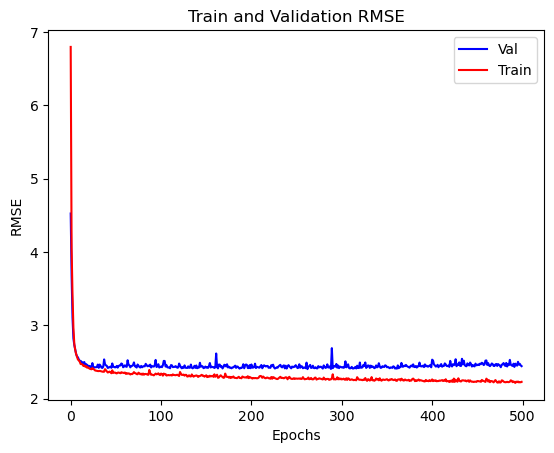

-----------------------------------------------------------------------
TRAINING
RMSE = 2.1974856041076185
MAE 1.6565093916456972
R2 0.8619820822413814
-----------------------------------------------------------------------
TESTING
RMSE = 3.989119711622486
MAE 2.8578188306379526
R2 0.6125477222274406


In [81]:
# Points

print("POINTS")
print("-----------------------------------------------------------------------")


# val split
X_train, X_val, y_train, y_val = train_test_split(np_stat_X_train, np_stat_pts_train, \
                                                        test_size=0.2, random_state=42)
X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
B_opt = 128
# Dataloader format
trainset = MLPDataset(X_train, y_train)
valset = MLPDataset(X_val, y_val)
testset = MLPDataset(np_stat_X_test, np_stat_pts_test)

# Run training and validation loop
# Save the quickest model to converge

n_epochs = 30

## Vary batchsizes for smallest run-time
# Sample batchsizes for training  
batchsizes_dict = {16: None, 32: None, 64: None, 128: None, 256: None} # to store runtimes
rts = [] # for runtimes

for B in batchsizes_dict:

    # print(f"Batch size = {B}")

    seeder = 33

    # refresh model for a fair iteration
    model = MLP(n_fts, n_hid)
    model.to(device)
    # for refreshed model
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

    best_rmse = 1000
    train_loss_history = []
    val_loss_history = []

    # time marker
    start = time()
    # Iterate over epochs
    # (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
    for epoch in range(n_epochs):
        # print(f"Epoch {epoch+1} of {n_epochs}")
        seeder += 1
        # Shuffle the data at the start of each epoch (only useful for training set)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=B, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+seeder))
        valloader = torch.utils.data.DataLoader(valset, batch_size=B, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+seeder))
        
        train_loss, train_pred = train(model, trainloader, criterion, optimizer, device, disable=True) # Train
        val_loss, val_pred = validate(model, valloader, criterion, device, disable=True) # Validate
        # mark the end of this epoch's training
        runtime = time() - start
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        Converged = False
        if val_loss < best_rmse: # Save best model
            # print("Updating best model")
            best_loss = val_loss
            # torch.save(model.state_dict(), "best_model_pts.pt") # saving model parameters ("state_dict") saves memory
        if val_loss <= 3 and train_loss <= 3: # convergence
            runtime_model = runtime
            Converged = True
            # print("Attained Stopping Condition")
            break
    if Converged:
        rts.append(runtime_model)
    else:
        rts.append(runtime)
    
    # print("-----------------------------------------------------------------------")

# Complete the dictionary
for key, val in zip(batchsizes_dict, rts):
    batchsizes_dict[key] = round(val, 3)

B_opt = min(batchsizes_dict, key=batchsizes_dict.get)
print(f"Batch size of {B_opt} converges the fastest")

# Run training and validation loop
# Save the best model 
n_epochs = 100
epochs = torch.arange(n_epochs)
best_loss = 1000

## Define grid for hyperparameter optimization
lrs = [1e-3, 1e-2, 1e-1] 
reg_vals = [1e-4, 1e-3, 1e-2]

lr_opt = 0
reg_val_opt = 0

for lr in lrs:
    for reg_val in reg_vals:
        # print(f"Learning rate = {lr} and Lambda = {reg_val}")

        model = MLP(n_fts=n_fts, n_hid=n_hid)
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

        # (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
        for epoch in range(n_epochs): # Iterate over epochs
            # if (epoch+1)%10 == 0:
                # print(f"Epoch {epoch+1} of {n_epochs}")
            # Shuffle the data at the start of each epoch (only useful for training set)
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=B_opt, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+epoch))
            valloader = torch.utils.data.DataLoader(valset, batch_size=B_opt, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+epoch))
            
            train_loss, train_pred = train(model, trainloader, criterion, optimizer, device) # Train
            val_loss, val_pred = validate(model, valloader, criterion, device) # Validate
            
        if val_loss < best_loss: # Save best model
            best_loss = val_loss
            lr_opt = lr
            reg_val_opt = reg_val
            # torch.save(model.state_dict(), "best_model_pts.pt") # saving model parameters ("state_dict") saves memory

        # print("-------------------------------------------------------------------------------------")

## Report Best Hyperparameters from Grid Search
print("Best Model Training Hyperparameters:")
print(f"Learning Rate = {lr_opt}\nLambda = {reg_val_opt}")

# Run training and validation loop
# Save the best model
n_epochs = 500

seeder = 33

model = MLP(n_fts=n_fts, n_hid=n_hid)
model.to(device)
# for refreshed model
optimizer = optim.AdamW(model.parameters(), lr=lr_opt, weight_decay=reg_val_opt)

best_loss = 1000
val_list = []
train_list = []
# Iterate over epochs
# (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
for epoch in range(n_epochs):
    # if (epoch+1)%100 == 0:
        # print(f"Epoch {epoch+1} of {n_epochs}")

    seeder += 1
    # Shuffle the data at the start of each epoch (only useful for training set)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=B_opt, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+seeder))
    valloader = torch.utils.data.DataLoader(valset, batch_size=B_opt, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+seeder))
    
    train_loss, train_pred = train(model, trainloader, criterion, optimizer, device, disable=True) # Train
    val_loss, val_pred = validate(model, valloader, criterion, device, disable=True) # Validate
    train_list.append(train_loss)
    val_list.append(val_loss)
    
    if val_loss < best_loss: # best val accuracy over epochs
        best_loss = val_loss
        # print("Updating best model")
        loss_train = train_loss
        y_val_pred = val_pred
        torch.save(model.state_dict(), "NN_stat_best_model_pts.pt")

plt.figure()
plt.plot(range(n_epochs), val_list, color='blue')
plt.plot(range(n_epochs), train_list, color='red')
plt.title("Train and Validation RMSE")
plt.legend(["Val", "Train"])
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

# Metrics

mlp = MLP(n_fts=n_fts, n_hid=n_hid)
mlp.load_state_dict(torch.load("NN_stat_best_model_pts.pt"))

trainloader = DataLoader(trainset, batch_size=B_opt, shuffle=False)
err, y_train_pred = validate(model, trainloader, criterion, device)
y_train_pred = y_train_pred.reshape(len(y_train_pred),)

print("-----------------------------------------------------------------------")
print("TRAINING")
print("RMSE =", mean_squared_error(y_train, y_train_pred, squared=False))
print("MAE", mean_absolute_error(y_train, y_train_pred))
print("R2", r2_score(y_train, y_train_pred))
print("-----------------------------------------------------------------------")

testloader = DataLoader(testset, batch_size=B_opt, shuffle=False)
err, y_test_pred = validate(model, testloader, criterion, device)
y_test_pred = y_test_pred.reshape(len(y_test_pred),)
y_test = np_stat_pts_test

print("TESTING")
print("RMSE =", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE", mean_absolute_error(y_test, y_test_pred))
print("R2", r2_score(y_test, y_test_pred))

#### (b) For Rebounds

REBOUNDS
-----------------------------------------------------------------------
Batch size of 256 converges the fastest
Best Model Training Hyperparameters:
Learning Rate = 0.1
Lambda = 0.01


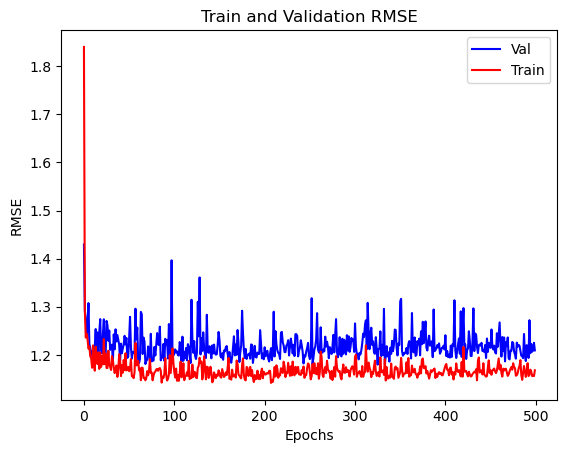

-----------------------------------------------------------------------
TRAINING
RMSE = 1.144141785058795
MAE 0.8412817095329579
R2 0.784560333439964
-----------------------------------------------------------------------
TESTING
RMSE = 2.49326697999456
MAE 1.634323939610777
R2 -0.08027341785403252


In [84]:
# Rebounds

print("REBOUNDS")
print("-----------------------------------------------------------------------")


# val split
X_train, X_val, y_train, y_val = train_test_split(np_stat_X_train, np_stat_reb_train, \
                                                        test_size=0.2, random_state=42)
X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)                                                        
B_opt = 128
# Dataloader format
trainset = MLPDataset(X_train, y_train)
valset = MLPDataset(X_val, y_val)
testset = MLPDataset(np_stat_X_test, np_stat_reb_test)

# Run training and validation loop
# Save the quickest model to converge

n_epochs = 30

## Vary batchsizes for smallest run-time
# Sample batchsizes for training  
batchsizes_dict = {16: None, 32: None, 64: None, 128: None, 256: None} # to store runtimes
rts = [] # for runtimes

for B in batchsizes_dict:

    # print(f"Batch size = {B}")

    seeder = 33

    # refresh model for a fair iteration
    model = MLP(n_fts, n_hid)
    model.to(device)
    # for refreshed model
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

    best_rmse = 1000
    train_loss_history = []
    val_loss_history = []

    # time marker
    start = time()
    # Iterate over epochs
    # (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
    for epoch in range(n_epochs):
        # print(f"Epoch {epoch+1} of {n_epochs}")
        seeder += 1
        # Shuffle the data at the start of each epoch (only useful for training set)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=B, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+seeder))
        valloader = torch.utils.data.DataLoader(valset, batch_size=B, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+seeder))
        
        train_loss, train_pred = train(model, trainloader, criterion, optimizer, device, disable=True) # Train
        val_loss, val_pred = validate(model, valloader, criterion, device, disable=True) # Validate
        # mark the end of this epoch's training
        runtime = time() - start
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        Converged = False
        if val_loss < best_rmse: # Save best model
            # print("Updating best model")
            best_loss = val_loss
            # torch.save(model.state_dict(), "best_model_pts.pt") # saving model parameters ("state_dict") saves memory
        if val_loss <= 1.5 and train_loss <= 1.5: # convergence
            runtime_model = runtime
            Converged = True
            # print("Attained Stopping Condition")
            break
    if Converged:
        rts.append(runtime_model)
    else:
        rts.append(runtime)
    
    # print("-----------------------------------------------------------------------")

# Complete the dictionary
for key, val in zip(batchsizes_dict, rts):
    batchsizes_dict[key] = round(val, 3)

B_opt = min(batchsizes_dict, key=batchsizes_dict.get)
print(f"Batch size of {B_opt} converges the fastest")

# Run training and validation loop
# Save the best model 
n_epochs = 100
epochs = torch.arange(n_epochs)
best_loss = 1000

## Define grid for hyperparameter optimization
lrs = [1e-3, 1e-2, 1e-1] 
reg_vals = [1e-3, 1e-2, 1e-1]

lr_opt = 0
reg_val_opt = 0

for lr in lrs:
    for reg_val in reg_vals:
        # print(f"Learning rate = {lr} and Lambda = {reg_val}")

        model = MLP(n_fts=n_fts, n_hid=n_hid)
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

        # (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
        for epoch in range(n_epochs): # Iterate over epochs
            # if (epoch+1)%10 == 0:
                # print(f"Epoch {epoch+1} of {n_epochs}")
            # Shuffle the data at the start of each epoch (only useful for training set)
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=B_opt, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+epoch))
            valloader = torch.utils.data.DataLoader(valset, batch_size=B_opt, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+epoch))
            
            train_loss, train_pred = train(model, trainloader, criterion, optimizer, device) # Train
            val_loss, val_pred = validate(model, valloader, criterion, device) # Validate
            
        if val_loss < best_loss: # Save best model
            best_loss = val_loss
            lr_opt = lr
            reg_val_opt = reg_val
            # torch.save(model.state_dict(), "best_model_pts.pt") # saving model parameters ("state_dict") saves memory

        # print("-------------------------------------------------------------------------------------")

## Report Best Hyperparameters from Grid Search
print("Best Model Training Hyperparameters:")
print(f"Learning Rate = {lr_opt}\nLambda = {reg_val_opt}")

# Run training and validation loop
# Save the best model
n_epochs = 500

seeder = 33

model = MLP(n_fts=n_fts, n_hid=n_hid)
model.to(device)
# for refreshed model
optimizer = optim.AdamW(model.parameters(), lr=lr_opt, weight_decay=reg_val_opt)

best_loss = 1000
val_list = []
train_list = []
# Iterate over epochs
# (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
for epoch in range(n_epochs):
    # if (epoch+1)%100 == 0:
        # print(f"Epoch {epoch+1} of {n_epochs}")

    seeder += 1
    # Shuffle the data at the start of each epoch (only useful for training set)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=B_opt, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+seeder))
    valloader = torch.utils.data.DataLoader(valset, batch_size=B_opt, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+seeder))
    
    train_loss, train_pred = train(model, trainloader, criterion, optimizer, device, disable=True) # Train
    val_loss, val_pred = validate(model, valloader, criterion, device, disable=True) # Validate
    train_list.append(train_loss)
    val_list.append(val_loss)
    
    if val_loss < best_loss: # best val accuracy over epochs
        best_loss = val_loss
        # print("Updating best model")
        torch.save(model.state_dict(), "NN_stat_best_model_reb.pt")

plt.figure()
plt.plot(range(n_epochs), val_list, color='blue')
plt.plot(range(n_epochs), train_list, color='red')
plt.title("Train and Validation RMSE")
plt.legend(["Val", "Train"])
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

# Metrics

mlp = MLP(n_fts=n_fts, n_hid=n_hid)
mlp.load_state_dict(torch.load("NN_stat_best_model_reb.pt"))

trainloader = DataLoader(trainset, batch_size=B_opt, shuffle=False)
err, y_train_pred = validate(model, trainloader, criterion, device)
y_train_pred = y_train_pred.reshape(len(y_train_pred),)

print("-----------------------------------------------------------------------")
print("TRAINING")
print("RMSE =", mean_squared_error(y_train, y_train_pred, squared=False))
print("MAE", mean_absolute_error(y_train, y_train_pred))
print("R2", r2_score(y_train, y_train_pred))
print("-----------------------------------------------------------------------")

testloader = DataLoader(testset, batch_size=B_opt, shuffle=False)
err, y_test_pred = validate(model, testloader, criterion, device)
y_test_pred = y_test_pred.reshape(len(y_test_pred),)
y_test = np_stat_reb_test

print("TESTING")
print("RMSE =", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE", mean_absolute_error(y_test, y_test_pred))
print("R2", r2_score(y_test, y_test_pred))

#### (c) For Assists

ASSISTS
-----------------------------------------------------------------------
Batch size of 128 converges the fastest
Best Model Training Hyperparameters:
Learning Rate = 0.01
Lambda = 0.01


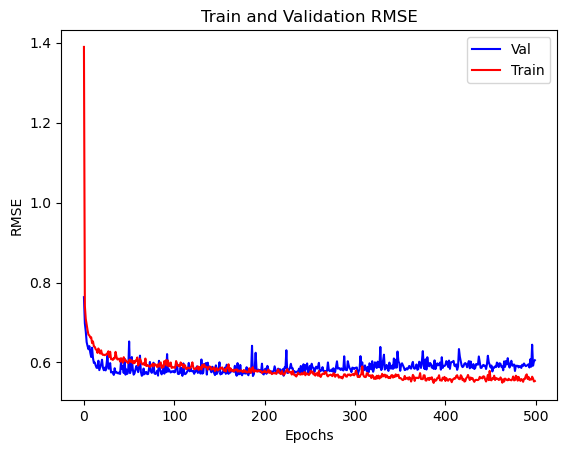

-----------------------------------------------------------------------
TRAINING
RMSE = 0.5615214993700517
MAE 0.3807195411427581
R2 0.9025602106099537
-----------------------------------------------------------------------
TESTING
RMSE = 0.871277854855151
MAE 0.5414256638054243
R2 0.7776907217945286


In [85]:
# Assists

print("ASSISTS")
print("-----------------------------------------------------------------------")


# val split
X_train, X_val, y_train, y_val = train_test_split(np_stat_X_train, np_stat_ast_train, \
                                                        test_size=0.2, random_state=42)
X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)

# Dataloader format
trainset = MLPDataset(X_train, y_train)
valset = MLPDataset(X_val, y_val)
testset = MLPDataset(np_stat_X_test, np_stat_ast_test)

# Run training and validation loop
# Save the quickest model to converge

n_epochs = 30

## Vary batchsizes for smallest run-time
# Sample batchsizes for training  
batchsizes_dict = {16: None, 32: None, 64: None, 128: None, 256: None} # to store runtimes
rts = [] # for runtimes

for B in batchsizes_dict:

    # print(f"Batch size = {B}")

    seeder = 33

    # refresh model for a fair iteration
    model = MLP(n_fts, n_hid)
    model.to(device)
    # for refreshed model
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

    best_rmse = 1000
    train_loss_history = []
    val_loss_history = []

    # time marker
    start = time()
    # Iterate over epochs
    # (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
    for epoch in range(n_epochs):
        # print(f"Epoch {epoch+1} of {n_epochs}")
        seeder += 1
        # Shuffle the data at the start of each epoch (only useful for training set)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=B, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+seeder))
        valloader = torch.utils.data.DataLoader(valset, batch_size=B, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+seeder))
        
        train_loss, train_pred = train(model, trainloader, criterion, optimizer, device, disable=True) # Train
        val_loss, val_pred = validate(model, valloader, criterion, device, disable=True) # Validate
        # mark the end of this epoch's training
        runtime = time() - start
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        Converged = False
        if val_loss < best_rmse: # Save best model
            # print("Updating best model")
            best_loss = val_loss
            # torch.save(model.state_dict(), "best_model_pts.pt") # saving model parameters ("state_dict") saves memory
        if val_loss <= 1 and train_loss <= 1: # convergence
            runtime_model = runtime
            Converged = True
            # print("Attained Stopping Condition")
            break
    if Converged:
        rts.append(runtime_model)
    else:
        rts.append(runtime)
    
    # print("-----------------------------------------------------------------------")

# Complete the dictionary
for key, val in zip(batchsizes_dict, rts):
    batchsizes_dict[key] = round(val, 3)

B_opt = min(batchsizes_dict, key=batchsizes_dict.get)
print(f"Batch size of {B_opt} converges the fastest")

# Run training and validation loop
# Save the best model 
n_epochs = 100
epochs = torch.arange(n_epochs)
best_loss = 1000

## Define grid for hyperparameter optimization
lrs = [1e-3, 1e-2, 1e-1] 
reg_vals = [1e-4, 1e-3, 1e-2]

lr_opt = 0
reg_val_opt = 0

for lr in lrs:
    for reg_val in reg_vals:
        # print(f"Learning rate = {lr} and Lambda = {reg_val}")

        model = MLP(n_fts=n_fts, n_hid=n_hid)
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg_val)

        # (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
        for epoch in range(n_epochs): # Iterate over epochs
            # if (epoch+1)%10 == 0:
                # print(f"Epoch {epoch+1} of {n_epochs}")
            # Shuffle the data at the start of each epoch (only useful for training set)
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=B_opt, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+epoch))
            valloader = torch.utils.data.DataLoader(valset, batch_size=B_opt, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+epoch))
            
            train_loss, train_pred = train(model, trainloader, criterion, optimizer, device) # Train
            val_loss, val_pred = validate(model, valloader, criterion, device) # Validate
            
        if val_loss < best_loss: # Save best model
            best_loss = val_loss
            lr_opt = lr
            reg_val_opt = reg_val
            # torch.save(model.state_dict(), "best_model_pts.pt") # saving model parameters ("state_dict") saves memory

        # print("-------------------------------------------------------------------------------------")

## Report Best Hyperparameters from Grid Search
print("Best Model Training Hyperparameters:")
print(f"Learning Rate = {lr_opt}\nLambda = {reg_val_opt}")

# Run training and validation loop
# Save the best model
n_epochs = 500

seeder = 33

model = MLP(n_fts=n_fts, n_hid=n_hid)
model.to(device)
# for refreshed model
optimizer = optim.AdamW(model.parameters(), lr=lr_opt, weight_decay=reg_val_opt)

best_loss = 1000
val_list = []
train_list = []
# Iterate over epochs
# (sourced from /lecture/fmnist_mlp_torch.ipynb of Course Github)
for epoch in range(n_epochs):
    # if (epoch+1)%100 == 0:
        # print(f"Epoch {epoch+1} of {n_epochs}")

    seeder += 1
    # Shuffle the data at the start of each epoch (only useful for training set)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=B_opt, shuffle=True, worker_init_fn=lambda id: np.random.seed(id+seeder))
    valloader = torch.utils.data.DataLoader(valset, batch_size=B_opt, shuffle=False, worker_init_fn=lambda id: np.random.seed(id+seeder))
    
    train_loss, train_pred = train(model, trainloader, criterion, optimizer, device, disable=True) # Train
    val_loss, val_pred = validate(model, valloader, criterion, device, disable=True) # Validate
    train_list.append(train_loss)
    val_list.append(val_loss)
    
    if val_loss < best_loss: # best val accuracy over epochs
        best_loss = val_loss
        # print("Updating best model")
        loss_train = train_loss
        y_val_pred = val_pred
        torch.save(model.state_dict(), "NN_stat_best_model_ast.pt")

plt.figure()
plt.plot(range(n_epochs), val_list, color='blue')
plt.plot(range(n_epochs), train_list, color='red')
plt.title("Train and Validation RMSE")
plt.legend(["Val", "Train"])
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

# Metrics

mlp = MLP(n_fts=n_fts, n_hid=n_hid)
mlp.load_state_dict(torch.load("NN_stat_best_model_ast.pt"))

trainloader = DataLoader(trainset, batch_size=B_opt, shuffle=False)
err, y_train_pred = validate(model, trainloader, criterion, device)
y_train_pred = y_train_pred.reshape(len(y_train_pred),)

print("-----------------------------------------------------------------------")
print("TRAINING")
print("RMSE =", mean_squared_error(y_train, y_train_pred, squared=False))
print("MAE", mean_absolute_error(y_train, y_train_pred))
print("R2", r2_score(y_train, y_train_pred))
print("-----------------------------------------------------------------------")

testloader = DataLoader(testset, batch_size=B_opt, shuffle=False)
err, y_test_pred = validate(model, testloader, criterion, device)
y_test_pred = y_test_pred.reshape(len(y_test_pred),)
y_test = np_stat_ast_test

print("TESTING")
print("RMSE =", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE", mean_absolute_error(y_test, y_test_pred))
print("R2", r2_score(y_test, y_test_pred))

## III - Classification: Draft Number and Stage

### Libraries

In [86]:
## Import classification libraries

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.neural_network import MLPClassifier

### Preprocessing

In [87]:
df_aux = df_all.copy(deep=True)

df_aux['draft_number'].replace('Undrafted', 0, inplace=True)
df_aux['draft_number'] = df_aux['draft_number'].astype('int64')
df_aux['draft_round'].replace('Undrafted', 0, inplace=True)
df_aux['draft_round'] = df_aux['draft_round'].astype('int64')
last_draft = max(df_aux['draft_number'])
last_round = max(df_aux['draft_round'])
last_draft, last_round

(165, 8)

In [88]:
## Clean column data and create new columns to reflect that
def Df_Cleaner(df_):
    # Unchanged original df
    df = df_.copy(deep=True)

    ## Draft Number
    df['draft_number'].replace('Undrafted', last_draft+10, inplace=True) # Encode undrafted as last draft
    draft_number_list = df['draft_number'].astype('int64') # convert all strings to int
    ## Bin Draft numbers into highest multiple of 10 lower than them
    draft_number_list = np.array(draft_number_list)
    draft_number_list = np.floor(draft_number_list/10).astype(int) * 10
    draft_number_list = draft_number_list.tolist()
    df['draft_number'] = draft_number_list

    ## Draft Round
    df['draft_round'].replace('Undrafted', last_round+1, inplace=True) # Encode undrafted as last draft
    round_list = df['draft_round'].astype('int64') # convert all strings to int
    df['draft_round'] = round_list
    
    ## Draft year and season
    # Take the ending year of the season
    year_list = []
    for i, val in enumerate(df['season']):
        year_list.append(int(val.split('-')[0]) + 1)
    df['year_list'] = year_list

    # Convert undrafted to 0 for draft_year
    df['draft_year'].replace('Undrafted', 0, inplace=True)
    draft_year_list = df['draft_year'].astype('int64') # Convert all years into int type
    df['draft_year'] = draft_year_list
    
    # Count experience
    df['Experience'] = df['year_list'] - df['draft_year']
    # Make undrafted values back to zero (for neutral math effect)
    exp_list = []
    for i, val in enumerate(df['Experience']):
        if val > 100:
            exp_list.append(0)
        else:
            exp_list.append(int(val))
    # Ensure experience is int type
    df['Experience'] = exp_list
 
    ## Drop draft number and draft year columns
    df.drop(['player_name', 'draft_year', 'season', 'year_list'], axis=1, inplace=True)

    return df

## Preprocess all columns
def Df_RegOneHot(df_):
    # Unchanged original df
    df = df_.copy(deep=True)

    # Columns for one-hot encoding
    df = pd.get_dummies(data=df, columns=['team_abbreviation', 'college', 'country'])
    
    # # MinMax Scaling
    # mm_scaler = MinMaxScaler()
    # df[mm_cols] = mm_scaler.fit_transform(df[mm_cols])

    # # Robust Scaling
    # rb_scaler = RobustScaler()
    # df[rb_cols] = rb_scaler.fit_transform(df[rb_cols])

    return df

In [89]:
# Clean the training dataframe
df_all_cleaned = Df_Cleaner(df_all)
df_all_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12305 entries, 0 to 12304
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   team_abbreviation  12305 non-null  object 
 1   age                12305 non-null  float64
 2   player_height      12305 non-null  float64
 3   player_weight      12305 non-null  float64
 4   college            12305 non-null  object 
 5   country            12305 non-null  object 
 6   draft_round        12305 non-null  int64  
 7   draft_number       12305 non-null  int64  
 8   gp                 12305 non-null  int64  
 9   pts                12305 non-null  float64
 10  reb                12305 non-null  float64
 11  ast                12305 non-null  float64
 12  net_rating         12305 non-null  float64
 13  oreb_pct           12305 non-null  float64
 14  dreb_pct           12305 non-null  float64
 15  usg_pct            12305 non-null  float64
 16  ts_pct             123

In [90]:
# Perform Preprocessing
df_all_preproc = Df_RegOneHot(df_all_cleaned)
df_all_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12305 entries, 0 to 12304
Columns: 481 entries, age to country_Yugoslavia
dtypes: float64(12), int64(4), uint8(465)
memory usage: 7.1 MB


### Features and Labels

In [91]:
# Separate X and y from train data
df_X = df_all_preproc.drop(['draft_round', 'draft_number'], axis=1)
df_y = df_all_preproc[['draft_round', 'draft_number']].copy()

# Convert to numpy arrays for ML
np_X = df_X.to_numpy()
np_y = df_y.to_numpy()
np_X.shape, np_y.shape

((12305, 479), (12305, 2))

In [92]:
# For the non one-hot encoded features
marker = 14

In [93]:
np_X_train, np_X_test, np_y_train, np_y_test = train_test_split(np_X, np_y, \
                                                                test_size=0.2, random_state=42)

np_round_train, np_round_test = np_y_train[:, 0], np_y_test[:, 0]
np_num_train, np_num_test = np_y_train[:, 1], np_y_test[:, 1]

In [94]:
np_X_train, mn_X, rng_X = ScaleCols(X=np_X_train, marker=marker)
np_X_test, _, _ = ScaleCols(X=np_X_test, marker=marker)

In [95]:
# Function for plotting confusion matrix
def PlotConfMat(conf_mat):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(x=i, y=j, s=conf_mat[i, j], va='center', ha='center')
    
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

def PolynomialTransforms(X, marker, degree=1):
    poly_fts = PolynomialFeatures(degree)
    poly_X = poly_fts.fit_transform(X[:, :marker])     # apply transforms to certain columns
    X_fin = np.hstack((poly_X, X[:, marker:]))
    return X_fin

### (i) Trivial System

TRAINING
Draft Round Accuracy = 0.42503047541649736
Draft Stage Accuracy = 0.16446566436407964
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.11180343282524796
Draft Stage Macro-F1 =  0.07605618708308012
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


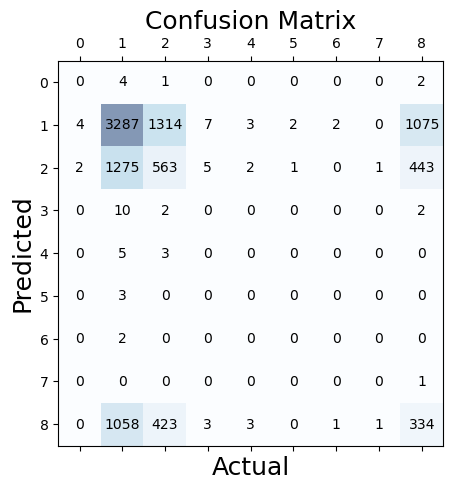

Draft Stage Conf. Mat.


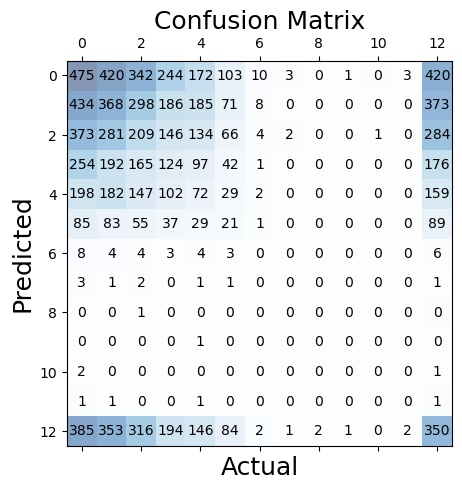

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
Draft Round Accuracy = 0.41934173100365707
Draft Stage Accuracy = 0.18122714343762697
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.12442374459996662
Draft Stage Macro-F1 =  0.09114256997257414
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


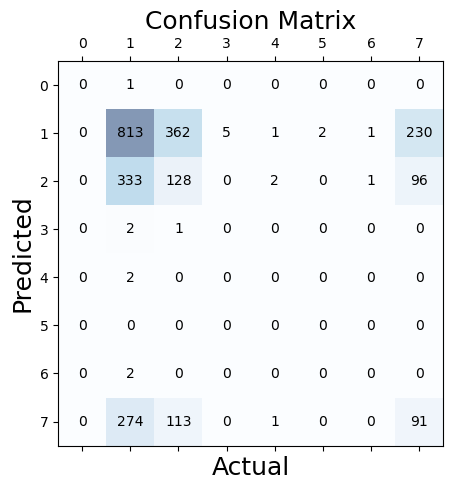

Draft Stage Conf. Mat.


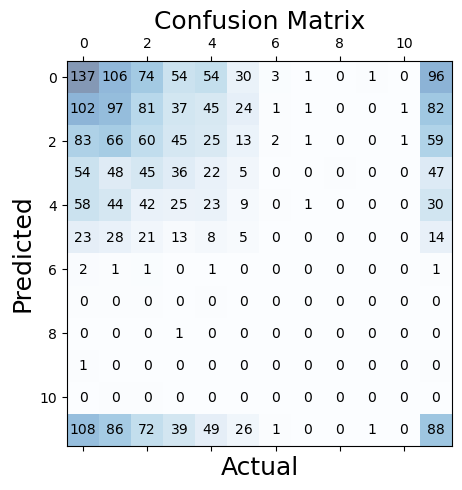

In [96]:
## Trivial System

# Get simple priors
round_unique, round_counts = np.unique(np_round_train, return_counts=True)
round_priors = round_counts / len(np_round_train)

num_unique, num_counts = np.unique(np_num_train, return_counts=True)
num_priors = num_counts / len(np_num_train)

# Training data

np_round_pred = np.empty_like(np_round_train)
np_num_pred = np.empty_like(np_num_train)
for i in range(len(np_round_pred)):
    np_round_pred[i] = np.random.choice(round_unique, p=round_priors)
    np_num_pred[i] = np.random.choice(num_unique, p=num_priors)

print("TRAINING")
# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_train, np_round_pred)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, np_num_pred)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_train, np_round_pred, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_train, np_num_pred, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_train, np_round_pred))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_train, np_num_pred))
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

# Testing Data

np_round_pred = np.empty_like(np_round_test)
np_num_pred = np.empty_like(np_num_test)
for i in range(len(np_round_pred)):
    np_round_pred[i] = np.random.choice(round_unique, p=round_priors)
    np_num_pred[i] = np.random.choice(num_unique, p=num_priors)

print("TESTING")
# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_test, np_round_pred)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, np_num_pred)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_test, np_round_pred, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_test, np_num_pred, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_test, np_round_pred))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_test, np_num_pred))

### (ii) Baseline System

TRAINING
Draft Round Accuracy = 0.5351483136936205
Draft Stage Accuracy = 0.3473181633482324
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.35146633706224034
Draft Stage Macro-F1 =  0.2558427721272855
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


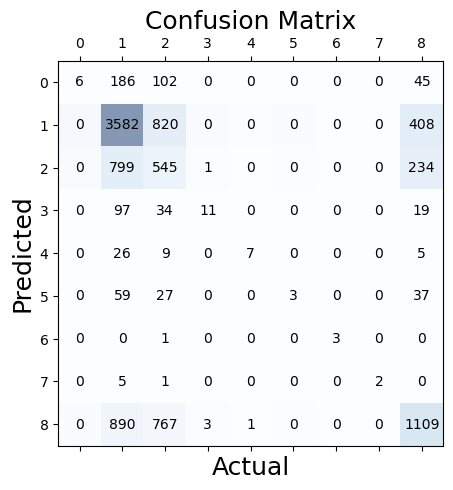

Draft Stage Conf. Mat.


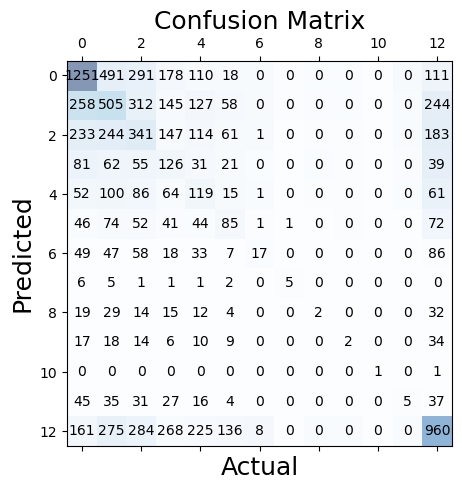

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
Draft Round Accuracy = 0.5481511580658269
Draft Stage Accuracy = 0.36164160910199106
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.313482744501163
Draft Stage Macro-F1 =  0.20644110262991378
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


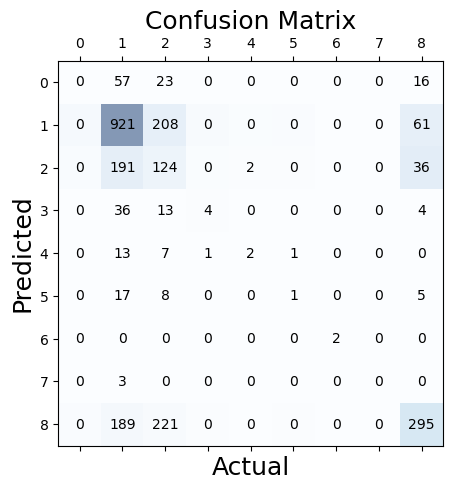

Draft Stage Conf. Mat.


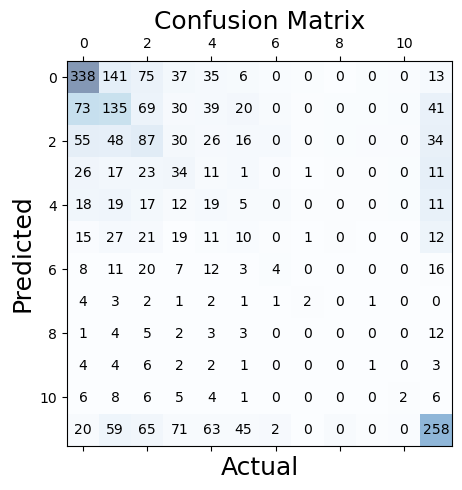

In [97]:
## Baseline System - Nearest Means

clf_round = NearestCentroid()
clf_round.fit(np_X_train, np_round_train)

clf_num = NearestCentroid()
clf_num.fit(np_X_train, np_num_train)

# Training data

np_round_pred = clf_round.predict(np_X_train)
np_num_pred = clf_num.predict(np_X_train)

print("TRAINING")
# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_train, np_round_pred)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, np_num_pred)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_train, np_round_pred, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_train, np_num_pred, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_train, np_round_pred))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_train, np_num_pred))
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

# Testing Data

np_round_pred = clf_round.predict(np_X_test)
np_num_pred = clf_num.predict(np_X_test)

print("TESTING")
# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_test, np_round_pred)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, np_num_pred)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_test, np_round_pred, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_test, np_num_pred, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_test, np_round_pred))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_test, np_num_pred))

### (iii) Multinomial Ridge Classification 

In [98]:
## Multinomial Ridge Classifier - OvR

degrees = [3, 4, 5]
lamdas = [1e-3, 3e-3, 0.01]

# best_params_round = {'degree': 1, 'lamda': 0}
# best_params_num = {'degree': 1, 'lamda': 0}
best_params_round = {'degree': 4, 'lamda': 0.01}
best_params_num = {'degree': 4, 'lamda': 0.001}

# # to isolate best model
# best_acc_round = 0
# best_acc_num = 0
# counter=0
# for degree in degrees:
#     for lamda in lamdas:
#         counter+=1
#         print(counter)
#         clf = OneVsRestClassifier(RidgeClassifier(alpha=lamda))
        
#         X_train, X_val, y_train, y_val = train_test_split(np_X_train, np_y_train, \
#                                                         test_size=0.2, random_state=42)
#         X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
#         X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
        
#         X_train = PolynomialTransforms(X_train, marker, degree=degree)
#         X_val = PolynomialTransforms(X_val, marker, degree=degree)
        
#         # Draft Round
#         round_train, round_val = y_train[:, 0], y_val[:, 0]
#         clf.fit(X_train, round_train)
#         round_pred = clf.predict(X_val)
#         # Decide on Accuracy
#         acc_round = accuracy_score(round_val, round_pred)
#         if (acc_round > best_acc_round):
#             best_acc_round = acc_round
#             best_params_round['degree'] = degree
#             best_params_round['lamda'] = lamda

#         # Draft Stage
#         num_train, num_val = y_train[:, 1], y_val[:, 1]
#         clf.fit(X_train, num_train)
#         num_pred = clf.predict(X_val)
#         # Decide on Accuracy
#         acc_num = accuracy_score(num_val, num_pred)
#         if (acc_num > best_acc_num):
#             best_acc_num = acc_num
#             best_params_num['degree'] = degree
#             best_params_num['lamda'] = lamda

print("Best Params for Draft Round =", best_params_round)
print("Best Params for Draft Stage =", best_params_num)

Best Params for Draft Round = {'degree': 4, 'lamda': 0.01}
Best Params for Draft Stage = {'degree': 4, 'lamda': 0.001}


TRAINING
Draft Round Accuracy = 0.8503657049979683
Draft Stage Accuracy = 0.7062169849654611
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.7469179286848813
Draft Stage Macro-F1 =  0.6651838601811009
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


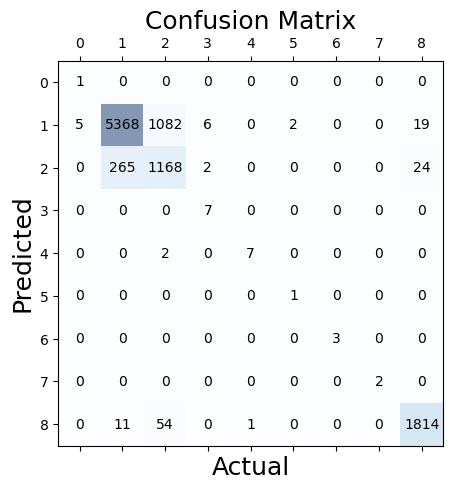

Draft Stage Conf. Mat.


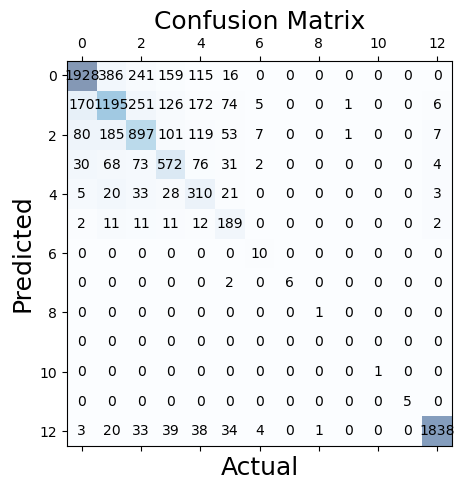

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
Draft Round Accuracy = 0.6269809020723284
Draft Stage Accuracy = 0.42584315318976024
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.5078761236733088
Draft Stage Macro-F1 =  0.274032789874505
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


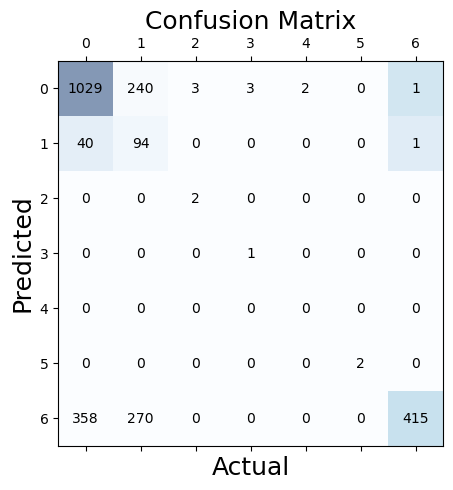

Draft Stage Conf. Mat.


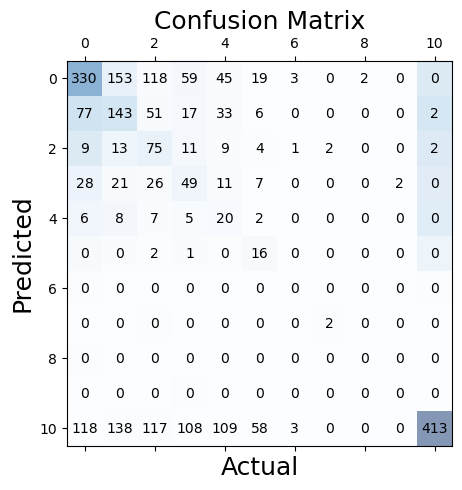

In [99]:
## Results

# Draft Round
reg_round = OneVsRestClassifier(RidgeClassifier(alpha=best_params_round['lamda']))
np_X1_train = PolynomialTransforms(np_X_train, marker, degree=best_params_round['degree'])
np_X1_test = PolynomialTransforms(np_X_test, marker, degree=best_params_round['degree'])
reg_round.fit(np_X1_train, np_round_train)
# Draft Stage
reg_num = OneVsRestClassifier(RidgeClassifier(alpha=best_params_num['lamda']))
np_X2_train = PolynomialTransforms(np_X_train, marker, degree=best_params_num['degree'])
np_X2_test = PolynomialTransforms(np_X_test, marker, degree=best_params_num['degree'])
reg_num.fit(np_X2_train, np_num_train)

print('TRAINING')
round_reg = reg_round.predict(np_X1_train)
num_reg = reg_num.predict(np_X2_train)

# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_train, round_reg)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, num_reg)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_train, round_reg, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_train, num_reg, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_train, round_reg))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_train, num_reg))
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
round_reg = reg_round.predict(np_X1_test)
num_reg = reg_num.predict(np_X2_test)

# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_test, round_reg)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, num_reg)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_test, round_reg, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_test, num_reg, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_test, round_reg))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_test, num_reg))

### (iv) Support Vector Classification

In [100]:
##Support Vector Classifier - OvR

# best_params_round = {'kernel': 'linear', 'degree': 1, 'gamma': 10, 'C': 1}
# best_params_num = {'kernel': 'linear', 'degree': 1, 'gamma': 10, 'C': 1}
best_params_round = {'kernel': 'poly', 'degree': 4, 'gamma': 3, 'C': 0.01}
best_params_num = {'kernel': 'poly', 'degree': 4, 'gamma': 3, 'C': 0.01}

# # grids for search 
# kernels = ['rbf', 'sigmoid', 'poly']
# degrees = [3, 4, 5]
# gammas = [0.3, 1, 3]
# Cs = [0.01, 0.03, 0.1]

# # to isolate best model
# best_acc_round = 0
# best_acc_num = 0
# counter = 0
# for kernel in kernels:
#     for gamma in gammas:
#         for C in Cs:
#             for degree in degrees:
#                 Breaker = True
#                 if kernel == 'poly':
#                     Breaker = False
#                 counter+=1
#                 print(counter)
#                 clf = OneVsRestClassifier(SVC(C=C, kernel=kernel, degree=degree, gamma=gamma))
#                 X_train, X_val, y_train, y_val = train_test_split(np_X_train, np_y_train, \
#                                                                     test_size=0.2, random_state=42)
#                 X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
#                 X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
                
#                 # Draft Round
#                 round_train, round_val = y_train[:, 0], y_val[:, 0]
#                 clf.fit(X_train, round_train)
#                 round_pred = clf.predict(X_val)
#                 # Decide on Accuracy
#                 acc_round = accuracy_score(round_val, round_pred)
#                 if (acc_round > best_acc_round):
#                     best_acc_round = acc_round
#                     best_params_round['kernel'] = kernel
#                     best_params_round['degree'] = degree
#                     best_params_round['gamma'] = gamma
#                     best_params_round['C'] = C

#                 # Draft Stage
#                 num_train, num_val = y_train[:, 1], y_val[:, 1]
#                 clf.fit(X_train, num_train)
#                 num_pred = clf.predict(X_val)
#                 # Decide on Accuracy
#                 acc_num = accuracy_score(num_val, num_pred)
#                 if (acc_num > best_acc_num):
#                     best_acc_num = acc_num
#                     best_params_num['kernel'] = kernel
#                     best_params_num['degree'] = degree
#                     best_params_num['gamma'] = gamma
#                     best_params_num['C'] = C

#                 if Breaker:
#                     break

print("Best Params for Draft Round =", best_params_round)
print("Best Params for Draft Stage =", best_params_num)

Best Params for Draft Round = {'kernel': 'poly', 'degree': 4, 'gamma': 3, 'C': 0.01}
Best Params for Draft Stage = {'kernel': 'poly', 'degree': 4, 'gamma': 3, 'C': 0.01}


TRAINING
Draft Round Accuracy = 0.9994920763917107
Draft Stage Accuracy = 0.9991873222267371
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.9998103145530605
Draft Stage Macro-F1 =  0.9996115807061461
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


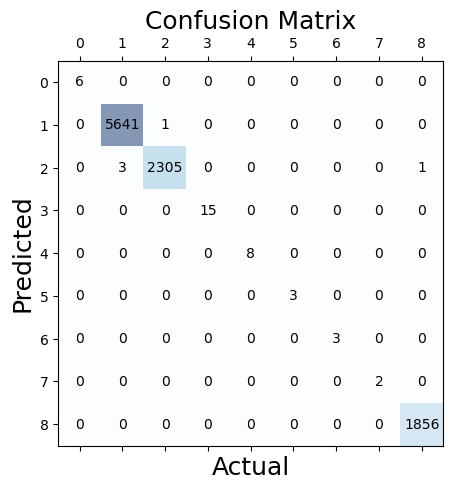

Draft Stage Conf. Mat.


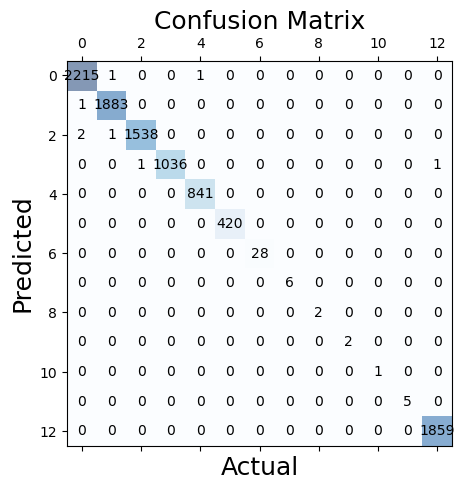

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
Draft Round Accuracy = 0.8256806176351077
Draft Stage Accuracy = 0.7553839902478667
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.5735506500656496
Draft Stage Macro-F1 =  0.5944806831640831
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


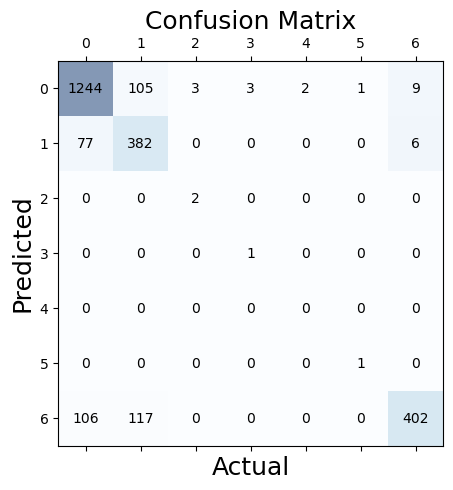

Draft Stage Conf. Mat.


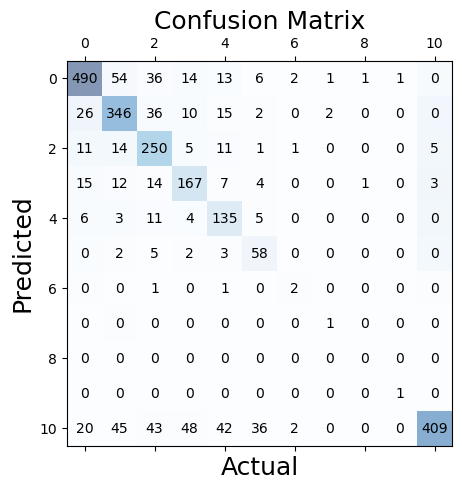

In [101]:
## Results

# Draft Round
svc_round = OneVsRestClassifier(SVC(kernel=best_params_round['kernel'], degree=best_params_round['degree'],\
                                    gamma=best_params_round['gamma'], C=best_params_round['C']))
svc_round.fit(np_X_train, np_round_train)
# Draft Stage
svc_num = OneVsRestClassifier(SVC(kernel=best_params_round['kernel'], degree=best_params_round['degree'],\
                                    gamma=best_params_round['gamma'], C=best_params_round['C']))
svc_num.fit(np_X_train, np_num_train)

print('TRAINING')
round_svc = svc_round.predict(np_X_train)
num_svc = svc_num.predict(np_X_train)

# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_train, round_svc)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, num_svc)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_train, round_svc, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_train, num_svc, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_train, round_svc))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_train, num_svc))
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
round_svc = svc_round.predict(np_X_test)
num_svc = svc_num.predict(np_X_test)

# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_test, round_svc)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, num_svc)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_test, round_svc, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_test, num_svc, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_test, round_svc))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_test, num_svc))

### (v) Probabilistic Models

#### (a) KNN

In [102]:
## KNN Classifier

Ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

best_params_round = {'K': 1}
best_params_num = {'K': 1}

# to isolate best model
best_acc_round = 0
best_acc_num = 0

for K in Ks:
    clf = KNeighborsClassifier(n_neighbors=K)
    
    X_train, X_val, y_train, y_val = train_test_split(np_X_train, np_y_train, \
                                                    test_size=0.2, random_state=42)
    X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
    X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
    
    
    # Draft Round
    round_train, round_val = y_train[:, 0], y_val[:, 0]
    clf.fit(X_train, round_train)
    round_pred = clf.predict(X_val)
    # Decide on Accuracy
    acc_round = accuracy_score(round_val, round_pred)
    if (acc_round > best_acc_round):
        best_acc_round = acc_round
        best_params_round['K'] = K

    # Draft Stage
    num_train, num_val = y_train[:, 1], y_val[:, 1]
    clf.fit(X_train, num_train)
    num_pred = clf.predict(X_val)
    # Decide on Accuracy
    acc_num = accuracy_score(num_val, num_pred)
    if (acc_num > best_acc_num):
        best_acc_num = acc_num
        best_params_num['K'] = K
        
print("Best Params for Draft Round =", best_params_round)
print("Best Params for Draft Stage =", best_params_num)

Best Params for Draft Round = {'K': 2}
Best Params for Draft Stage = {'K': 2}


TRAINING
Draft Round Accuracy = 0.8925233644859814
Draft Stage Accuracy = 0.8544290938642828
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.8107948490153409
Draft Stage Macro-F1 =  0.7266334752444822
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


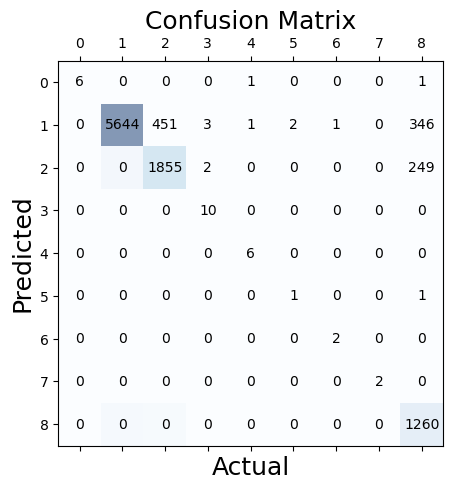

Draft Stage Conf. Mat.


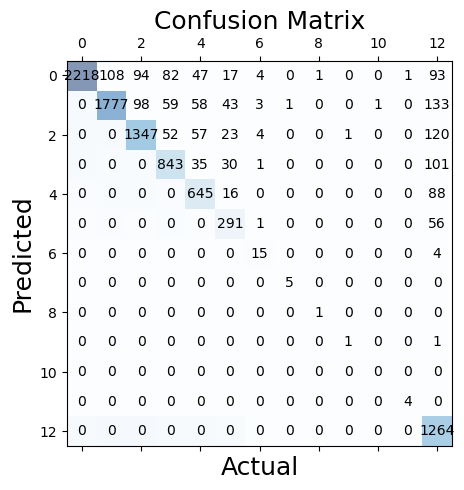

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
Draft Round Accuracy = 0.7801706623323852
Draft Stage Accuracy = 0.6712718407151564
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.430212535395145
Draft Stage Macro-F1 =  0.5071463646218816
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


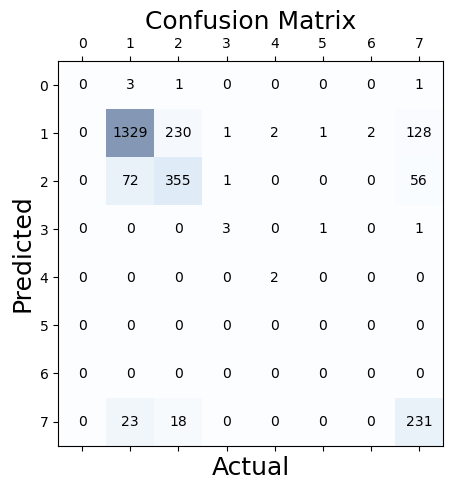

Draft Stage Conf. Mat.


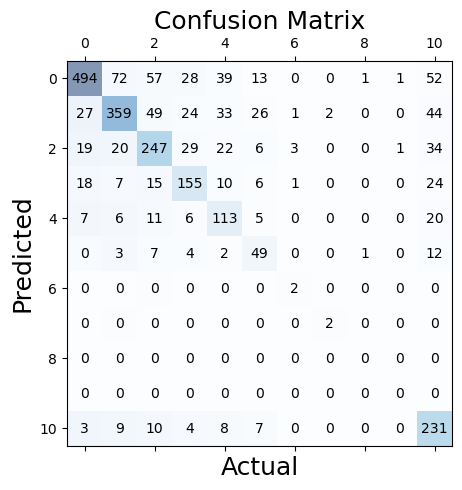

In [103]:
## Results

# Draft Round
knn_round = KNeighborsClassifier(n_neighbors=best_params_round['K'])
knn_round.fit(np_X_train, np_round_train)
# Draft Stage
knn_num = KNeighborsClassifier(n_neighbors=best_params_num['K'])
knn_num.fit(np_X_train, np_num_train)

print('TRAINING')
round_knn = knn_round.predict(np_X_train)
num_knn = knn_num.predict(np_X_train)

# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_train, round_knn)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, num_knn)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_train, round_knn, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_train, num_knn, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_train, round_knn))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_train, num_knn))
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
round_knn = knn_round.predict(np_X_test)
num_knn = knn_num.predict(np_X_test)

# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_test, round_knn)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, num_knn)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_test, round_knn, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_test, num_knn, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_test, round_knn))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_test, num_knn))

#### (b) Naive Bayes

TRAINING
Draft Round Accuracy = 0.4900446972775295
Draft Stage Accuracy = 0.24603819585534337
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.5459707742439195
Draft Stage Macro-F1 =  0.5272596216797789
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


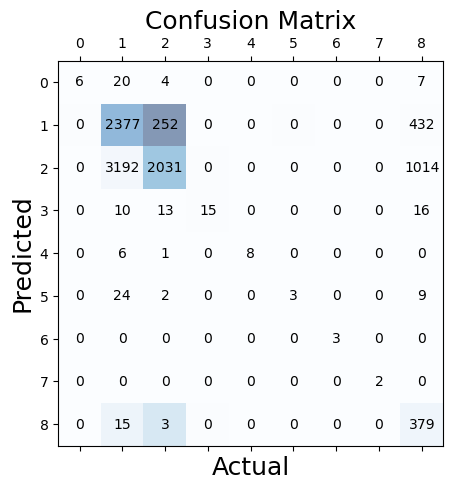

Draft Stage Conf. Mat.


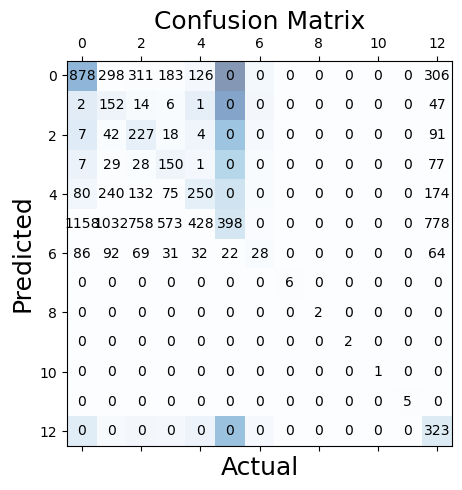

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
Draft Round Accuracy = 0.4668833807395368
Draft Stage Accuracy = 0.22754977651361236
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.3292227592569871
Draft Stage Macro-F1 =  0.2504104940691145
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


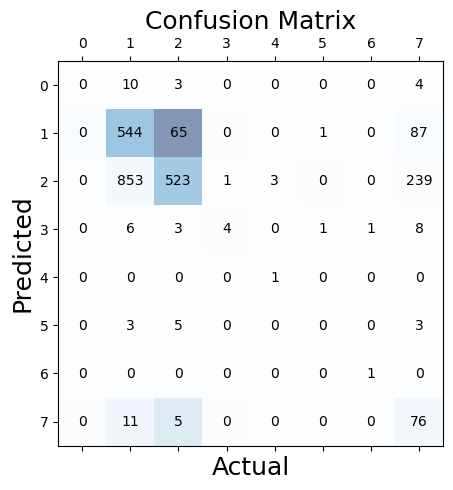

Draft Stage Conf. Mat.


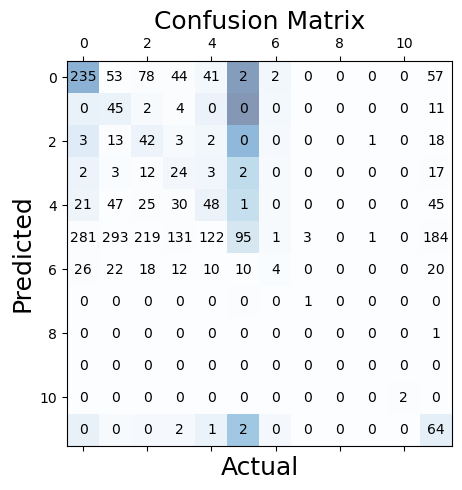

In [104]:
## Naive Bayes Classifier

nb_round = GaussianNB()
nb_round.fit(np_X_train, np_round_train)

nb_num = GaussianNB()
nb_num.fit(np_X_train, np_num_train)

# Training data

np_round_pred = nb_round.predict(np_X_train)
np_num_pred = nb_num.predict(np_X_train)

print("TRAINING")
# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_train, np_round_pred)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, np_num_pred)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_train, np_round_pred, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_train, np_num_pred, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_train, np_round_pred))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_train, np_num_pred))
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

# Testing Data

np_round_pred = nb_round.predict(np_X_test)
np_num_pred = nb_num.predict(np_X_test)

print("TESTING")
# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_test, np_round_pred)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, np_num_pred)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_test, np_round_pred, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_test, np_num_pred, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_test, np_round_pred))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_test, np_num_pred))

#### (c) Complement Naive Bayes

TRAINING
Draft Round Accuracy = 0.6726940268183665
Draft Stage Accuracy = 0.47186103210077207
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.59576970378055
Draft Stage Macro-F1 =  0.4646707975497202
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


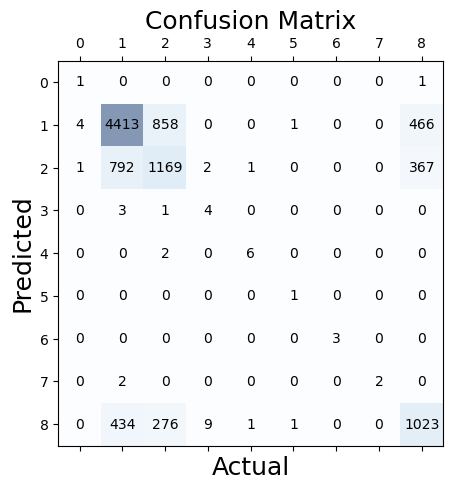

Draft Stage Conf. Mat.


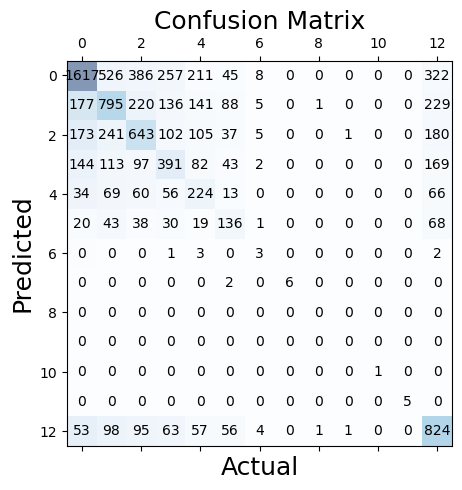

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
Draft Round Accuracy = 0.65826899634295
Draft Stage Accuracy = 0.4412840308817554
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.4655769116869063
Draft Stage Macro-F1 =  0.3622125883316301
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


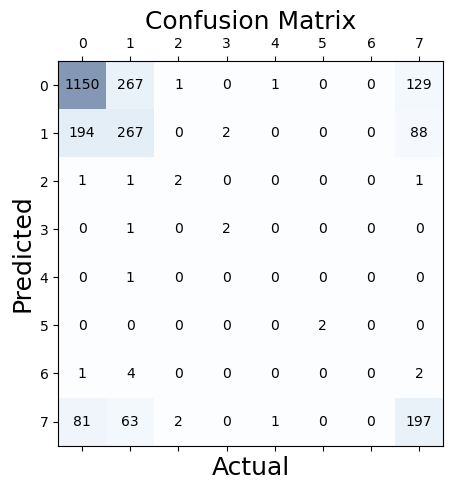

Draft Stage Conf. Mat.


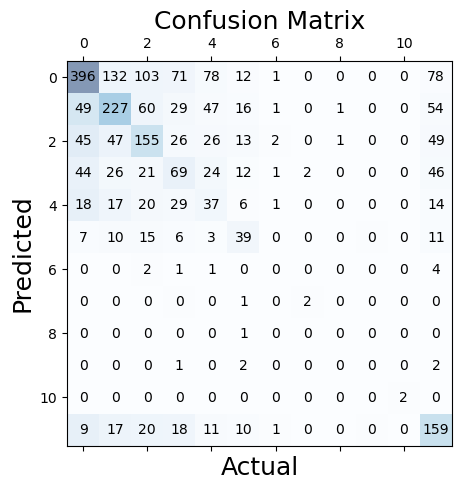

In [105]:
## Complement Naive Bayes Classifier

# Use MinMaxScaler for acceptable input into Complement NB

sc = MinMaxScaler()
np_X1_train = sc.fit_transform(np_X_train)
np_X1_test = sc.fit_transform(np_X_test)


nb_round = ComplementNB()
nb_round.fit(np_X1_train, np_round_train)

nb_num = ComplementNB()
nb_num.fit(np_X1_train, np_num_train)

# Training data

np_round_pred = nb_round.predict(np_X1_train)
np_num_pred = nb_num.predict(np_X1_train)

print("TRAINING")
# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_train, np_round_pred)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, np_num_pred)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_train, np_round_pred, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_train, np_num_pred, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_train, np_round_pred))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_train, np_num_pred))
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

# Testing Data

np_round_pred = nb_round.predict(np_X1_test)
np_num_pred = nb_num.predict(np_X1_test)

print("TESTING")
# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_test, np_round_pred)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, np_num_pred)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_test, np_round_pred, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_test, np_num_pred, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_test, np_round_pred))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_test, np_num_pred))

### (vi) Neural Network

In [108]:
## MLP for Draft Round

best_params_round = {'alpha': 0, 'lr': 0}
best_params_num = {'alpha': 0, 'lr': 0}

# grids for search 
alphas = [1e-3, 1e-2, 1e-1, 1]
lrs = [1e-4, 1e-3, 1e-2]

# to isolate best model
best_acc_round = 0
best_acc_num = 0
for alpha in alphas:
    for lr in lrs:
                clf_round = MLPClassifier(hidden_layer_sizes=((64, 32)),\
                                    alpha=alpha, learning_rate_init=lr,\
                                    max_iter=300, random_state=42,\
                                    early_stopping=True, validation_fraction=0.1)
                clf_num = MLPClassifier(hidden_layer_sizes=((128, 64)),\
                                    alpha=alpha, learning_rate_init=lr,\
                                    max_iter=300, random_state=42,\
                                    early_stopping=True, validation_fraction=0.1)
                clf_round.out_activation_ = 'softmax'
                clf_num.out_activation_ = 'softmax'
                
                X_train, X_val, y_train, y_val = train_test_split(np_X_train, np_y_train, \
                                                                    test_size=0.2, random_state=42)
                X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
                X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
                
                # Draft Round
                round_train, round_val = y_train[:, 0], y_val[:, 0]
                clf_round.fit(X_train, round_train)
                round_pred = clf_round.predict(X_val)
                # Decide on Accuracy
                acc_round = accuracy_score(round_val, round_pred)
                if (acc_round > best_acc_round):
                    best_acc_round = acc_round
                    best_params_round['alpha'] = alpha
                    best_params_round['lr'] = lr

                # Draft Stage
                num_train, num_val = y_train[:, 1], y_val[:, 1]
                clf_num.fit(X_train, num_train)
                num_pred = clf_num.predict(X_val)
                # Decide on Accuracy
                acc_num = accuracy_score(num_val, num_pred)
                if (acc_num > best_acc_num):
                    best_acc_num = acc_num
                    best_params_num['alpha'] = alpha
                    best_params_num['lr'] = lr

print("Best Params for Draft Round =", best_params_round)
print("Best Params for Draft Stage =", best_params_num)

Best Params for Draft Round = {'alpha': 0.01, 'lr': 0.01}
Best Params for Draft Stage = {'alpha': 0.001, 'lr': 0.01}


TRAINING
Draft Round Accuracy = 0.9617025599349858
Draft Stage Accuracy = 0.000304754164973588
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.7089127876608197
Draft Stage Macro-F1 =  0.00012846865364850977
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


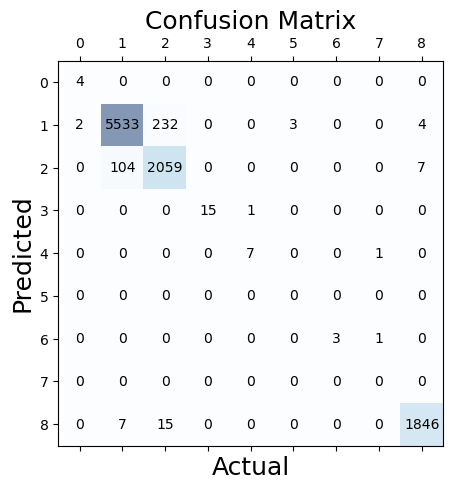

Draft Stage Conf. Mat.


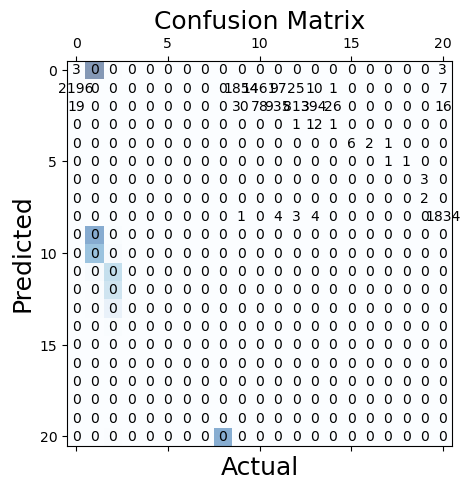

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
Draft Round Accuracy = 0.6724908573750508
Draft Stage Accuracy = 0.0
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.30550396691121096
Draft Stage Macro-F1 =  0.0
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


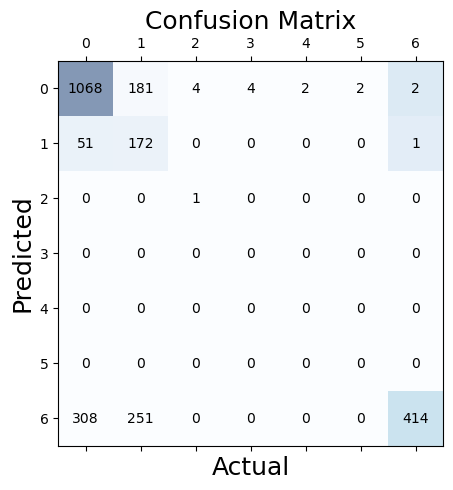

Draft Stage Conf. Mat.


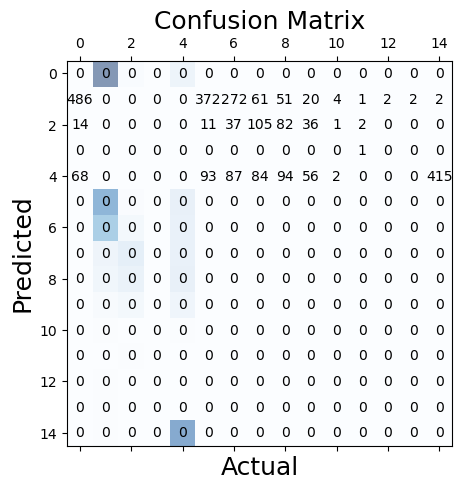

In [109]:
## Results

# Draft Round
mlp_round = MLPClassifier(hidden_layer_sizes=((64, 32)),\
                alpha=best_params_round['alpha'], learning_rate_init=best_params_round['lr'],\
                max_iter=300, random_state=42,\
                early_stopping=True, validation_fraction=0.1)
mlp_round.out_activation = 'softmax'
mlp_round.fit(np_X_train, np_round_train)

# Draft Stage
mlp_num = MLPClassifier(hidden_layer_sizes=((128, 64)),\
                alpha=best_params_num['alpha'], learning_rate_init=best_params_num['lr'],\
                max_iter=300, random_state=42,\
                early_stopping=True, validation_fraction=0.1)
mlp_num.out_activation_ = 'softmax'
mlp_num.fit(np_X_train, np_round_train)

print('TRAINING')
round_mlp = mlp_round.predict(np_X_train)
num_mlp = mlp_num.predict(np_X_train)

# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_train, round_mlp)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, num_mlp)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_train, round_mlp, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_train, num_mlp, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_train, round_mlp))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_train, num_mlp))
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
round_mlp = mlp_round.predict(np_X_test)
num_mlp = mlp_num.predict(np_X_test)

# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_test, round_mlp)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, num_mlp)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_test, round_mlp, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_test, num_mlp, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_test, round_mlp))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_test, num_mlp))